## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 100 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

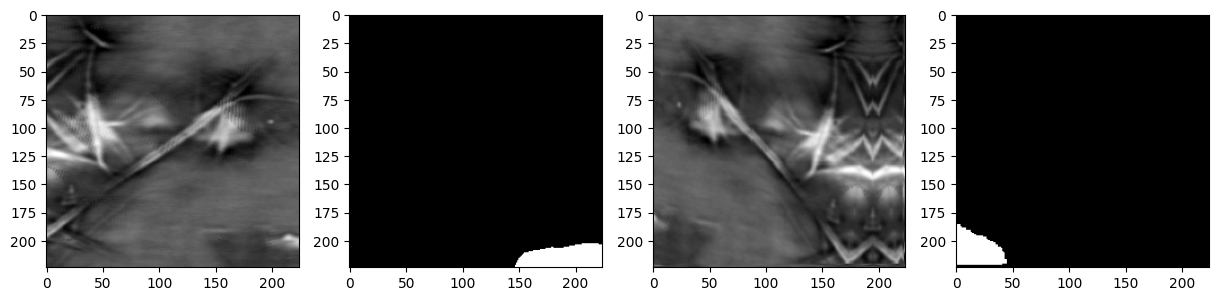

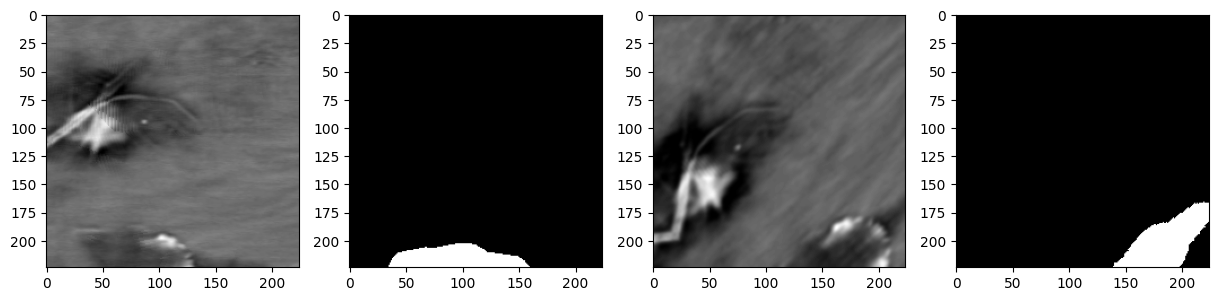

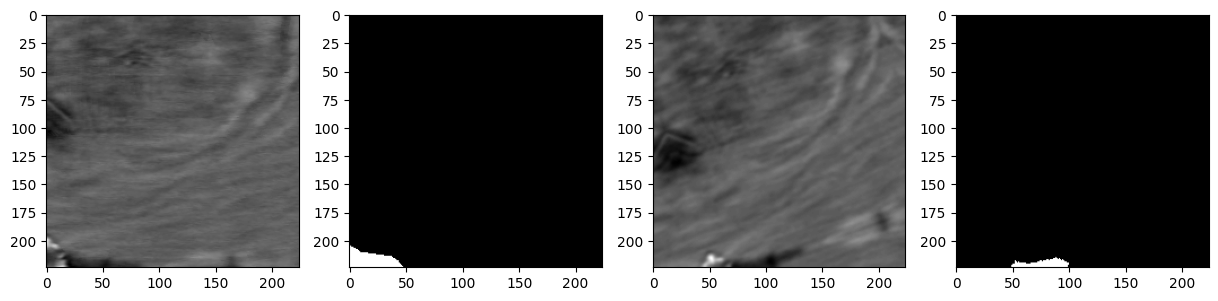

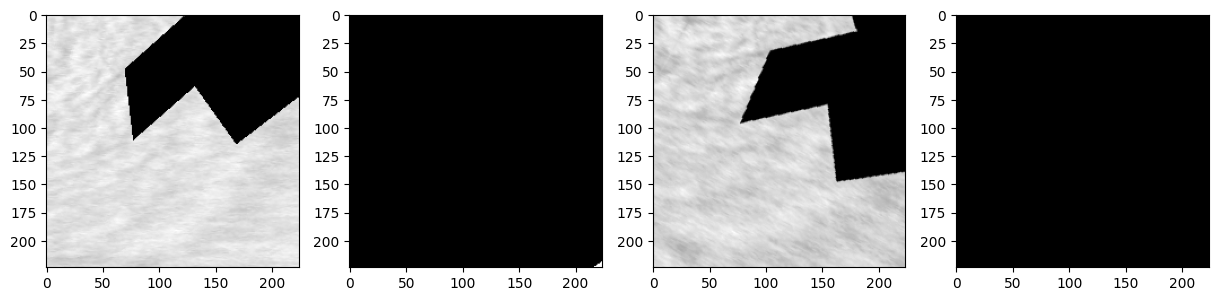

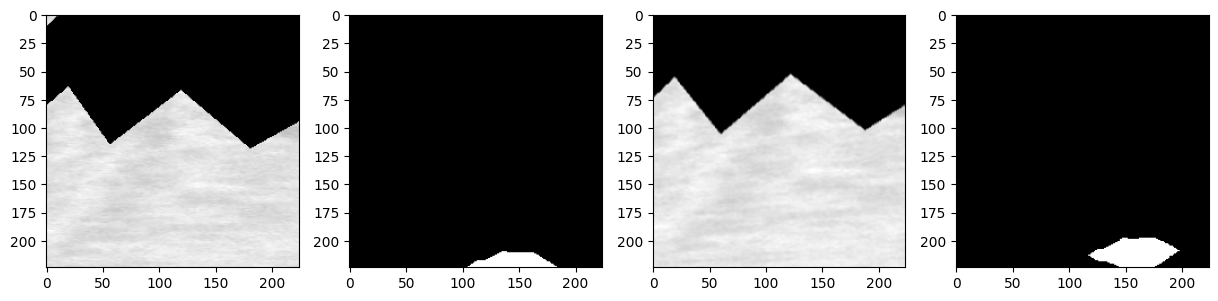

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

53836

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1209634083407585
th: 0.15, fbeta: 0.12093098983680294
th: 0.2, fbeta: 0.12181975906120004
th: 0.25, fbeta: 0.20852640053262564
th: 0.3, fbeta: 0.2219273476600319
th: 0.35, fbeta: 0.23285991992280192
th: 0.4, fbeta: 0.2209031317546461
th: 0.45, fbeta: 0.16758042516959443
th: 0.5, fbeta: 0.07508517089563616
th: 0.55, fbeta: 0.01896981292988141
th: 0.6, fbeta: 0.0036037345664619697
th: 0.65, fbeta: 0.0006581999747720112
th: 0.7, fbeta: 9.91925103996697e-05
th: 0.75, fbeta: 8.424254293407677e-06
th: 0.8, fbeta: 9.361362954997661e-07
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.23285991992280192
Epoch 1 - avg_train_loss: 0.6414  avg_val_loss: 0.4196  time: 30s
Epoch 1 - avgScore: 0.2329
Epoch 1 - Save Best Score: 0.2329 Model
Epoch 1 - Save Best Loss: 0.4196 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12101637394410615
th: 0.15, fbeta: 0.21810787940410414
th: 0.2, fbeta: 0.24614870776672
th: 0.25, fbeta: 0.30289552393574715
th: 0.3, fbeta: 0.34217490632093966
th: 0.35, fbeta: 0.3376066941765301
th: 0.4, fbeta: 0.23640115674676931
th: 0.45, fbeta: 0.062460584855182424
th: 0.5, fbeta: 0.004763882426178221
th: 0.55, fbeta: 0.0001881492742641413
th: 0.6, fbeta: 2.8088892919181584e-06
th: 0.65, fbeta: 0.0
th: 0.7, fbeta: 0.0
th: 0.75, fbeta: 0.0
th: 0.8, fbeta: 0.0
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.3, fbeta: 0.34217490632093966
Epoch 2 - avg_train_loss: 0.3946  avg_val_loss: 0.3245  time: 29s
Epoch 2 - avgScore: 0.3422
Epoch 2 - Save Best Score: 0.3422 Model
Epoch 2 - Save Best Loss: 0.3245 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.33099750189301796
th: 0.15, fbeta: 0.38084851400858327
th: 0.2, fbeta: 0.4082416010334801
th: 0.25, fbeta: 0.42279982072395356
th: 0.3, fbeta: 0.42680764564690027
th: 0.35, fbeta: 0.41078387370420427
th: 0.4, fbeta: 0.3395372560211742
th: 0.45, fbeta: 0.17317903332026754
th: 0.5, fbeta: 0.022137433855353824
th: 0.55, fbeta: 0.0001535341674469413
th: 0.6, fbeta: 0.0
th: 0.65, fbeta: 0.0
th: 0.7, fbeta: 0.0
th: 0.75, fbeta: 0.0
th: 0.8, fbeta: 0.0
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.3, fbeta: 0.42680764564690027
Epoch 3 - avg_train_loss: 0.2862  avg_val_loss: 0.2454  time: 28s
Epoch 3 - avgScore: 0.4268
Epoch 3 - Save Best Score: 0.4268 Model
Epoch 3 - Save Best Loss: 0.2454 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3758140792076627
th: 0.15, fbeta: 0.4021039999779824
th: 0.2, fbeta: 0.38199288696811284
th: 0.25, fbeta: 0.34242666421983764
th: 0.3, fbeta: 0.2948644379217514
th: 0.35, fbeta: 0.24827193114271062
th: 0.4, fbeta: 0.2005850450599609
th: 0.45, fbeta: 0.15739191689036633
th: 0.5, fbeta: 0.12141158062296334
th: 0.55, fbeta: 0.09050994693670142
th: 0.6, fbeta: 0.06386914340836047
th: 0.65, fbeta: 0.040767892845968
th: 0.7, fbeta: 0.024097671817126014
th: 0.75, fbeta: 0.009395883580581285
th: 0.8, fbeta: 0.001876541493799861
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.15, fbeta: 0.4021039999779824
Epoch 4 - avg_train_loss: 0.2542  avg_val_loss: 0.2695  time: 29s
Epoch 4 - avgScore: 0.4021


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38981243721683967
th: 0.15, fbeta: 0.4506472219146118
th: 0.2, fbeta: 0.46088738926020606
th: 0.25, fbeta: 0.4510940175058654
th: 0.3, fbeta: 0.43372397641816207
th: 0.35, fbeta: 0.4098290441537612
th: 0.4, fbeta: 0.378406066015824
th: 0.45, fbeta: 0.33708622049874315
th: 0.5, fbeta: 0.2904853209607101
th: 0.55, fbeta: 0.24077795464940382
th: 0.6, fbeta: 0.1873226533576133
th: 0.65, fbeta: 0.1372778502116637
th: 0.7, fbeta: 0.08882934724445947
th: 0.75, fbeta: 0.049234414031777876
th: 0.8, fbeta: 0.02102349445256167
th: 0.85, fbeta: 0.0014404004636303003
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.2, fbeta: 0.46088738926020606
Epoch 5 - avg_train_loss: 0.2443  avg_val_loss: 0.2506  time: 29s
Epoch 5 - avgScore: 0.4609
Epoch 5 - Save Best Score: 0.4609 Model
Epoch 5 - Save Best Loss: 0.2506 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41220045622960716
th: 0.15, fbeta: 0.4514334445865634
th: 0.2, fbeta: 0.460864879173678
th: 0.25, fbeta: 0.4663138303148368
th: 0.3, fbeta: 0.4597500941338795
th: 0.35, fbeta: 0.44997413369801714
th: 0.4, fbeta: 0.4307711555451181
th: 0.45, fbeta: 0.4024444996598603
th: 0.5, fbeta: 0.36005119517298023
th: 0.55, fbeta: 0.3061567015248412
th: 0.6, fbeta: 0.24122905857073748
th: 0.65, fbeta: 0.17042672004140821
th: 0.7, fbeta: 0.11033572936329128
th: 0.75, fbeta: 0.0607139105424015
th: 0.8, fbeta: 0.016462208043240084
th: 0.85, fbeta: 0.0008347146090661277
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.25, fbeta: 0.4663138303148368
Epoch 6 - avg_train_loss: 0.2396  avg_val_loss: 0.2570  time: 29s
Epoch 6 - avgScore: 0.4663
Epoch 6 - Save Best Score: 0.4663 Model
Epoch 6 - Save Best Loss: 0.2570 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.397912210458924
th: 0.15, fbeta: 0.44508518592925145
th: 0.2, fbeta: 0.4768819098391466
th: 0.25, fbeta: 0.49516190419381806
th: 0.3, fbeta: 0.5060809620477952
th: 0.35, fbeta: 0.5096904908322306
th: 0.4, fbeta: 0.5071022607248071
th: 0.45, fbeta: 0.4994728481558179
th: 0.5, fbeta: 0.48622439906492115
th: 0.55, fbeta: 0.4636444317132624
th: 0.6, fbeta: 0.42766955858348293
th: 0.65, fbeta: 0.37939485965279174
th: 0.7, fbeta: 0.3211240942447448
th: 0.75, fbeta: 0.2371461660139776
th: 0.8, fbeta: 0.10250843622028699
th: 0.85, fbeta: 0.014424921901947954
th: 0.9, fbeta: 6.929005591872619e-05
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.5096904908322306
Epoch 7 - avg_train_loss: 0.2309  avg_val_loss: 0.2492  time: 29s
Epoch 7 - avgScore: 0.5097
Epoch 7 - Save Best Score: 0.5097 Model
Epoch 7 - Save Best Loss: 0.2492 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3946252298760377
th: 0.15, fbeta: 0.43497413592525874
th: 0.2, fbeta: 0.4637137359064171
th: 0.25, fbeta: 0.47356391772171197
th: 0.3, fbeta: 0.46830703795106005
th: 0.35, fbeta: 0.45641922161314075
th: 0.4, fbeta: 0.43919907527951335
th: 0.45, fbeta: 0.41512286140314775
th: 0.5, fbeta: 0.3819103618951591
th: 0.55, fbeta: 0.33675343492776316
th: 0.6, fbeta: 0.2815780292209605
th: 0.65, fbeta: 0.22385491671093877
th: 0.7, fbeta: 0.17032873371878826
th: 0.75, fbeta: 0.11496489239459895
th: 0.8, fbeta: 0.06027999821049949
th: 0.85, fbeta: 0.011613444900325346
th: 0.9, fbeta: 0.0007477392481166366
th: 0.95, fbeta: 0.0


best_th: 0.25, fbeta: 0.47356391772171197
Epoch 8 - avg_train_loss: 0.2264  avg_val_loss: 0.2536  time: 29s
Epoch 8 - avgScore: 0.4736


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38856135044227047
th: 0.15, fbeta: 0.41802941786878267
th: 0.2, fbeta: 0.442032116413894
th: 0.25, fbeta: 0.46389045198623935
th: 0.3, fbeta: 0.4802761227533672
th: 0.35, fbeta: 0.4915026152469114
th: 0.4, fbeta: 0.4989795281361846
th: 0.45, fbeta: 0.500237898283454
th: 0.5, fbeta: 0.49403757429444334
th: 0.55, fbeta: 0.4822235865043074
th: 0.6, fbeta: 0.4588651838767746
th: 0.65, fbeta: 0.4178754086752391
th: 0.7, fbeta: 0.3599222973329159
th: 0.75, fbeta: 0.2744515450862431
th: 0.8, fbeta: 0.16060025018026272
th: 0.85, fbeta: 0.042134311274611404
th: 0.9, fbeta: 0.0021789195200311723
th: 0.95, fbeta: 0.0


best_th: 0.45, fbeta: 0.500237898283454
Epoch 9 - avg_train_loss: 0.2194  avg_val_loss: 0.2507  time: 29s
Epoch 9 - avgScore: 0.5002


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4683692873898838
th: 0.15, fbeta: 0.4839665354952501
th: 0.2, fbeta: 0.4966343953867501
th: 0.25, fbeta: 0.5012346427350567
th: 0.3, fbeta: 0.500155554469978
th: 0.35, fbeta: 0.4961835910711847
th: 0.4, fbeta: 0.4866625156529254
th: 0.45, fbeta: 0.46929612081956334
th: 0.5, fbeta: 0.4495730618885795
th: 0.55, fbeta: 0.4240091669773834
th: 0.6, fbeta: 0.3933335773348357
th: 0.65, fbeta: 0.3518754210631164
th: 0.7, fbeta: 0.3057359756954468
th: 0.75, fbeta: 0.24974132287196318
th: 0.8, fbeta: 0.17499818001988343
th: 0.85, fbeta: 0.09330736538002316
th: 0.9, fbeta: 0.03008539400438484
th: 0.95, fbeta: 0.0023926058425149596


best_th: 0.25, fbeta: 0.5012346427350567
Epoch 10 - avg_train_loss: 0.2153  avg_val_loss: 0.2716  time: 29s
Epoch 10 - avgScore: 0.5012


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42048962107686105
th: 0.15, fbeta: 0.4487593916657684
th: 0.2, fbeta: 0.4700358367976126
th: 0.25, fbeta: 0.4844307381697164
th: 0.3, fbeta: 0.49182374843846616
th: 0.35, fbeta: 0.4954276305473215
th: 0.4, fbeta: 0.49372536292618524
th: 0.45, fbeta: 0.4894199016962303
th: 0.5, fbeta: 0.4804466832813511
th: 0.55, fbeta: 0.45933589307980743
th: 0.6, fbeta: 0.42392007432224993
th: 0.65, fbeta: 0.38405815451591074
th: 0.7, fbeta: 0.3333500559018349
th: 0.75, fbeta: 0.27488656910995013
th: 0.8, fbeta: 0.20390108387683714
th: 0.85, fbeta: 0.11953618196586378
th: 0.9, fbeta: 0.042704536285045884
th: 0.95, fbeta: 0.0015758516089351218


best_th: 0.35, fbeta: 0.4954276305473215
Epoch 11 - avg_train_loss: 0.2056  avg_val_loss: 0.2685  time: 28s
Epoch 11 - avgScore: 0.4954


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43009176147272776
th: 0.15, fbeta: 0.4506079393118154
th: 0.2, fbeta: 0.4591567851851971
th: 0.25, fbeta: 0.4621124693611887
th: 0.3, fbeta: 0.4642831742391468
th: 0.35, fbeta: 0.461765202913635
th: 0.4, fbeta: 0.4490346413008141
th: 0.45, fbeta: 0.42763433215117935
th: 0.5, fbeta: 0.4011523268914504
th: 0.55, fbeta: 0.37050912220272697
th: 0.6, fbeta: 0.33488851712238754
th: 0.65, fbeta: 0.29405629824020046
th: 0.7, fbeta: 0.24437974688604158
th: 0.75, fbeta: 0.18881885175891028
th: 0.8, fbeta: 0.1360243259972724
th: 0.85, fbeta: 0.08344490018485357
th: 0.9, fbeta: 0.032971370370688126
th: 0.95, fbeta: 0.004333584012511776


best_th: 0.3, fbeta: 0.4642831742391468
Epoch 12 - avg_train_loss: 0.2023  avg_val_loss: 0.2946  time: 29s
Epoch 12 - avgScore: 0.4643


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4077266337104235
th: 0.15, fbeta: 0.44728498353654106
th: 0.2, fbeta: 0.4806767754077313
th: 0.25, fbeta: 0.505520675144284
th: 0.3, fbeta: 0.520382757606134
th: 0.35, fbeta: 0.5227309385493332
th: 0.4, fbeta: 0.5217418740117887
th: 0.45, fbeta: 0.5177675760640187
th: 0.5, fbeta: 0.5077881058416354
th: 0.55, fbeta: 0.49256068155795263
th: 0.6, fbeta: 0.46961116678972814
th: 0.65, fbeta: 0.43976604998236973
th: 0.7, fbeta: 0.40197624079387995
th: 0.75, fbeta: 0.35574352892365146
th: 0.8, fbeta: 0.2899759627280009
th: 0.85, fbeta: 0.20042871163359213
th: 0.9, fbeta: 0.09757957314692965
th: 0.95, fbeta: 0.022184074829280635


best_th: 0.35, fbeta: 0.5227309385493332
Epoch 13 - avg_train_loss: 0.2041  avg_val_loss: 0.2442  time: 29s
Epoch 13 - avgScore: 0.5227
Epoch 13 - Save Best Score: 0.5227 Model
Epoch 13 - Save Best Loss: 0.2442 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4383218130159949
th: 0.15, fbeta: 0.46685891344103814
th: 0.2, fbeta: 0.48825146628712235
th: 0.25, fbeta: 0.5004988274371615
th: 0.3, fbeta: 0.5042243621075841
th: 0.35, fbeta: 0.5049590806149284
th: 0.4, fbeta: 0.4952746952395549
th: 0.45, fbeta: 0.4785995117850305
th: 0.5, fbeta: 0.4539735913377232
th: 0.55, fbeta: 0.4250434419039209
th: 0.6, fbeta: 0.39350788873025383
th: 0.65, fbeta: 0.35830851254028895
th: 0.7, fbeta: 0.3157680535814644
th: 0.75, fbeta: 0.2611626139250825
th: 0.8, fbeta: 0.20104821792508154
th: 0.85, fbeta: 0.1414048190498151
th: 0.9, fbeta: 0.07282017752546936
th: 0.95, fbeta: 0.016746784995438475


best_th: 0.35, fbeta: 0.5049590806149284
Epoch 14 - avg_train_loss: 0.1981  avg_val_loss: 0.2859  time: 29s
Epoch 14 - avgScore: 0.5050


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4497267775171949
th: 0.15, fbeta: 0.48576948827071526
th: 0.2, fbeta: 0.5062980389241322
th: 0.25, fbeta: 0.5138003917090869
th: 0.3, fbeta: 0.5146167510810263
th: 0.35, fbeta: 0.5081702096313024
th: 0.4, fbeta: 0.49330426837523794
th: 0.45, fbeta: 0.47056489074213703
th: 0.5, fbeta: 0.44338138185356457
th: 0.55, fbeta: 0.41289260618175244
th: 0.6, fbeta: 0.38197801433636386
th: 0.65, fbeta: 0.3450301536663389
th: 0.7, fbeta: 0.30495230515633015
th: 0.75, fbeta: 0.25699467700053014
th: 0.8, fbeta: 0.20170910440832066
th: 0.85, fbeta: 0.13834007894732023
th: 0.9, fbeta: 0.06599369603845215
th: 0.95, fbeta: 0.015660254370550745


best_th: 0.3, fbeta: 0.5146167510810263
Epoch 15 - avg_train_loss: 0.1923  avg_val_loss: 0.2686  time: 29s
Epoch 15 - avgScore: 0.5146


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34024778488902696
th: 0.15, fbeta: 0.36363618644211565
th: 0.2, fbeta: 0.3823616237519556
th: 0.25, fbeta: 0.39881330393507397
th: 0.3, fbeta: 0.4156572505083068
th: 0.35, fbeta: 0.43016825545683013
th: 0.4, fbeta: 0.4448103701342779
th: 0.45, fbeta: 0.45804901226933503
th: 0.5, fbeta: 0.4673068505709642
th: 0.55, fbeta: 0.47764657492635176
th: 0.6, fbeta: 0.48337687812934893
th: 0.65, fbeta: 0.48372574566627535
th: 0.7, fbeta: 0.47894040777711816
th: 0.75, fbeta: 0.46602455365315687
th: 0.8, fbeta: 0.4381636318512063
th: 0.85, fbeta: 0.38082128061224985
th: 0.9, fbeta: 0.29267097879717835
th: 0.95, fbeta: 0.13227130462212372


best_th: 0.65, fbeta: 0.48372574566627535
Epoch 16 - avg_train_loss: 0.1878  avg_val_loss: 0.2787  time: 29s
Epoch 16 - avgScore: 0.4837


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3919323276634037
th: 0.15, fbeta: 0.42302540559824
th: 0.2, fbeta: 0.44743730723708136
th: 0.25, fbeta: 0.4662561188784424
th: 0.3, fbeta: 0.47874375044790307
th: 0.35, fbeta: 0.48758500323477827
th: 0.4, fbeta: 0.49127971182517777
th: 0.45, fbeta: 0.49457601231571824
th: 0.5, fbeta: 0.4903211017776327
th: 0.55, fbeta: 0.4762467161467168
th: 0.6, fbeta: 0.4572869223510868
th: 0.65, fbeta: 0.4328598008473914
th: 0.7, fbeta: 0.40063746927071786
th: 0.75, fbeta: 0.36048762830896336
th: 0.8, fbeta: 0.30226510847874516
th: 0.85, fbeta: 0.22967712397863585
th: 0.9, fbeta: 0.1389810469230917
th: 0.95, fbeta: 0.03540648655911817


best_th: 0.45, fbeta: 0.49457601231571824
Epoch 17 - avg_train_loss: 0.1826  avg_val_loss: 0.2544  time: 29s
Epoch 17 - avgScore: 0.4946


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3945489407932132
th: 0.15, fbeta: 0.4332977655894727
th: 0.2, fbeta: 0.46433366228256256
th: 0.25, fbeta: 0.4887939539853071
th: 0.3, fbeta: 0.5038584044268661
th: 0.35, fbeta: 0.5131863621985201
th: 0.4, fbeta: 0.5153856482287991
th: 0.45, fbeta: 0.5135586705707131
th: 0.5, fbeta: 0.5091005473665606
th: 0.55, fbeta: 0.49756028790787216
th: 0.6, fbeta: 0.4797692677217337
th: 0.65, fbeta: 0.4532368208502469
th: 0.7, fbeta: 0.42044030947891214
th: 0.75, fbeta: 0.3737325638674667
th: 0.8, fbeta: 0.3114183475379285
th: 0.85, fbeta: 0.23771531275552166
th: 0.9, fbeta: 0.1323483969977069
th: 0.95, fbeta: 0.03841541800521349


best_th: 0.4, fbeta: 0.5153856482287991
Epoch 18 - avg_train_loss: 0.1793  avg_val_loss: 0.2410  time: 29s
Epoch 18 - avgScore: 0.5154


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4917565369920695
th: 0.15, fbeta: 0.5080421813416973
th: 0.2, fbeta: 0.5146871129957585
th: 0.25, fbeta: 0.514668729168523
th: 0.3, fbeta: 0.5015250102268035
th: 0.35, fbeta: 0.47809643001070895
th: 0.4, fbeta: 0.4501538635112561
th: 0.45, fbeta: 0.4185148952873048
th: 0.5, fbeta: 0.38297778785995484
th: 0.55, fbeta: 0.3439589334897992
th: 0.6, fbeta: 0.3053645435229134
th: 0.65, fbeta: 0.2694569980715562
th: 0.7, fbeta: 0.2297553156090853
th: 0.75, fbeta: 0.18379077247470996
th: 0.8, fbeta: 0.13684898589019606
th: 0.85, fbeta: 0.09435809006702951
th: 0.9, fbeta: 0.05058062835699849
th: 0.95, fbeta: 0.00977025667955291


best_th: 0.2, fbeta: 0.5146871129957585
Epoch 19 - avg_train_loss: 0.1727  avg_val_loss: 0.3244  time: 29s
Epoch 19 - avgScore: 0.5147


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43841378867565167
th: 0.15, fbeta: 0.47250616405074913
th: 0.2, fbeta: 0.4926597389386801
th: 0.25, fbeta: 0.5056779387892728
th: 0.3, fbeta: 0.5144794841806446
th: 0.35, fbeta: 0.5168372071036007
th: 0.4, fbeta: 0.5141367842934566
th: 0.45, fbeta: 0.5055168364436052
th: 0.5, fbeta: 0.48889671275681706
th: 0.55, fbeta: 0.4698718602645926
th: 0.6, fbeta: 0.44448898063090503
th: 0.65, fbeta: 0.4115529686375884
th: 0.7, fbeta: 0.3757336918549433
th: 0.75, fbeta: 0.33667601582941503
th: 0.8, fbeta: 0.2878810324600535
th: 0.85, fbeta: 0.2303775493124161
th: 0.9, fbeta: 0.15943573277101913
th: 0.95, fbeta: 0.06625903906530098


best_th: 0.35, fbeta: 0.5168372071036007
Epoch 20 - avg_train_loss: 0.1712  avg_val_loss: 0.2854  time: 29s
Epoch 20 - avgScore: 0.5168


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4290195471370506
th: 0.15, fbeta: 0.45787434629130497
th: 0.2, fbeta: 0.4776781070850911
th: 0.25, fbeta: 0.49015490346654844
th: 0.3, fbeta: 0.49767313961116577
th: 0.35, fbeta: 0.4999638486813672
th: 0.4, fbeta: 0.4999868743247041
th: 0.45, fbeta: 0.49596863828583465
th: 0.5, fbeta: 0.48935946920490414
th: 0.55, fbeta: 0.47987476069325324
th: 0.6, fbeta: 0.46488758878399633
th: 0.65, fbeta: 0.44092870781790733
th: 0.7, fbeta: 0.4116293902359349
th: 0.75, fbeta: 0.376597483490208
th: 0.8, fbeta: 0.3339547852979606
th: 0.85, fbeta: 0.2763223373452407
th: 0.9, fbeta: 0.1997627835149278
th: 0.95, fbeta: 0.09118172305310021


best_th: 0.4, fbeta: 0.4999868743247041
Epoch 21 - avg_train_loss: 0.1664  avg_val_loss: 0.2830  time: 28s
Epoch 21 - avgScore: 0.5000


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4283335399153608
th: 0.15, fbeta: 0.46214164373913724
th: 0.2, fbeta: 0.4868388229580579
th: 0.25, fbeta: 0.5019981271769954
th: 0.3, fbeta: 0.5132615826634901
th: 0.35, fbeta: 0.5149400083738026
th: 0.4, fbeta: 0.5112067318102469
th: 0.45, fbeta: 0.5010307064584063
th: 0.5, fbeta: 0.48830494922556206
th: 0.55, fbeta: 0.4752485220290051
th: 0.6, fbeta: 0.4555193025200857
th: 0.65, fbeta: 0.42853362621702185
th: 0.7, fbeta: 0.39446885196280906
th: 0.75, fbeta: 0.3486551323461699
th: 0.8, fbeta: 0.29059451487502125
th: 0.85, fbeta: 0.21657385733452533
th: 0.9, fbeta: 0.12991966628388632
th: 0.95, fbeta: 0.030167544938506353


best_th: 0.35, fbeta: 0.5149400083738026
Epoch 22 - avg_train_loss: 0.1606  avg_val_loss: 0.2774  time: 29s
Epoch 22 - avgScore: 0.5149


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44246399389583635
th: 0.15, fbeta: 0.4658893038416197
th: 0.2, fbeta: 0.47122221700028116
th: 0.25, fbeta: 0.4727010660076119
th: 0.3, fbeta: 0.4683613855061098
th: 0.35, fbeta: 0.4573910034742127
th: 0.4, fbeta: 0.4402431772920325
th: 0.45, fbeta: 0.4180819194954345
th: 0.5, fbeta: 0.3937837394466726
th: 0.55, fbeta: 0.3646498140046209
th: 0.6, fbeta: 0.33282533834067274
th: 0.65, fbeta: 0.3050072038516476
th: 0.7, fbeta: 0.27736464564840074
th: 0.75, fbeta: 0.2429050446423273
th: 0.8, fbeta: 0.20705777861438712
th: 0.85, fbeta: 0.1691553470410918
th: 0.9, fbeta: 0.11588101606225974
th: 0.95, fbeta: 0.04689040556031316


best_th: 0.25, fbeta: 0.4727010660076119
Epoch 23 - avg_train_loss: 0.1627  avg_val_loss: 0.3355  time: 29s
Epoch 23 - avgScore: 0.4727


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41901720836435985
th: 0.15, fbeta: 0.44869887143213916
th: 0.2, fbeta: 0.47040801938748067
th: 0.25, fbeta: 0.4884957489943267
th: 0.3, fbeta: 0.4978917491562153
th: 0.35, fbeta: 0.5029875810901834
th: 0.4, fbeta: 0.502345436239749
th: 0.45, fbeta: 0.4962764764775149
th: 0.5, fbeta: 0.4875257077710236
th: 0.55, fbeta: 0.4747728979198891
th: 0.6, fbeta: 0.4561750414541623
th: 0.65, fbeta: 0.43146929491449715
th: 0.7, fbeta: 0.40420741849538366
th: 0.75, fbeta: 0.37443158398064863
th: 0.8, fbeta: 0.3382619717236056
th: 0.85, fbeta: 0.290076085288251
th: 0.9, fbeta: 0.22358701718497148
th: 0.95, fbeta: 0.12069766892213715


best_th: 0.35, fbeta: 0.5029875810901834
Epoch 24 - avg_train_loss: 0.1540  avg_val_loss: 0.2873  time: 29s
Epoch 24 - avgScore: 0.5030


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4052884648983097
th: 0.15, fbeta: 0.4372761310544658
th: 0.2, fbeta: 0.4621059990469114
th: 0.25, fbeta: 0.47999079693123603
th: 0.3, fbeta: 0.49370651774634206
th: 0.35, fbeta: 0.5019897359795007
th: 0.4, fbeta: 0.5047507941500419
th: 0.45, fbeta: 0.5011759946764491
th: 0.5, fbeta: 0.49413673981276685
th: 0.55, fbeta: 0.4786189211217221
th: 0.6, fbeta: 0.45297034394423386
th: 0.65, fbeta: 0.41970394004977785
th: 0.7, fbeta: 0.3814113684827703
th: 0.75, fbeta: 0.34198333174623846
th: 0.8, fbeta: 0.2926812005927348
th: 0.85, fbeta: 0.23275787093486222
th: 0.9, fbeta: 0.15929323806274234
th: 0.95, fbeta: 0.06085867597852828


best_th: 0.4, fbeta: 0.5047507941500419
Epoch 25 - avg_train_loss: 0.1516  avg_val_loss: 0.2832  time: 29s
Epoch 25 - avgScore: 0.5048


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4577302654098487
th: 0.15, fbeta: 0.4833059048332622
th: 0.2, fbeta: 0.501841418880936
th: 0.25, fbeta: 0.5144614738256136
th: 0.3, fbeta: 0.5156929807486468
th: 0.35, fbeta: 0.5104826287988197
th: 0.4, fbeta: 0.5013348091620464
th: 0.45, fbeta: 0.4876551273619236
th: 0.5, fbeta: 0.4695997253097873
th: 0.55, fbeta: 0.448799816629097
th: 0.6, fbeta: 0.4241824600948783
th: 0.65, fbeta: 0.3962352542491673
th: 0.7, fbeta: 0.36243704837542234
th: 0.75, fbeta: 0.322356251560397
th: 0.8, fbeta: 0.2825855133184734
th: 0.85, fbeta: 0.23162968428970848
th: 0.9, fbeta: 0.16254658401922326
th: 0.95, fbeta: 0.07565834315002339


best_th: 0.3, fbeta: 0.5156929807486468
Epoch 26 - avg_train_loss: 0.1472  avg_val_loss: 0.3176  time: 28s
Epoch 26 - avgScore: 0.5157


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4732025773743406
th: 0.15, fbeta: 0.5140406361844778
th: 0.2, fbeta: 0.5352980568255671
th: 0.25, fbeta: 0.5448280371563037
th: 0.3, fbeta: 0.5459062045809713
th: 0.35, fbeta: 0.5399734556236399
th: 0.4, fbeta: 0.5296004283908458
th: 0.45, fbeta: 0.5144822385208071
th: 0.5, fbeta: 0.4937056092421151
th: 0.55, fbeta: 0.4703880447543929
th: 0.6, fbeta: 0.4444151002930166
th: 0.65, fbeta: 0.414767249870443
th: 0.7, fbeta: 0.3850031539060954
th: 0.75, fbeta: 0.3536887294252025
th: 0.8, fbeta: 0.31803506407636056
th: 0.85, fbeta: 0.2723306615902862
th: 0.9, fbeta: 0.20457153835142527
th: 0.95, fbeta: 0.11635321798782597


best_th: 0.3, fbeta: 0.5459062045809713
Epoch 27 - avg_train_loss: 0.1527  avg_val_loss: 0.3050  time: 29s
Epoch 27 - avgScore: 0.5459
Epoch 27 - Save Best Score: 0.5459 Model
Epoch 27 - Save Best Loss: 0.3050 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44891625790039785
th: 0.15, fbeta: 0.47819301624967797
th: 0.2, fbeta: 0.4992010312830868
th: 0.25, fbeta: 0.5144978102610941
th: 0.3, fbeta: 0.5193593708094
th: 0.35, fbeta: 0.5174178768224889
th: 0.4, fbeta: 0.5121410010882156
th: 0.45, fbeta: 0.508875437889742
th: 0.5, fbeta: 0.5013206906761012
th: 0.55, fbeta: 0.4865224561203607
th: 0.6, fbeta: 0.46963428126007334
th: 0.65, fbeta: 0.449129789147234
th: 0.7, fbeta: 0.41768305300875874
th: 0.75, fbeta: 0.3811974587818482
th: 0.8, fbeta: 0.3331302333267803
th: 0.85, fbeta: 0.27562291693359825
th: 0.9, fbeta: 0.2019679596650697
th: 0.95, fbeta: 0.0964627394101414


best_th: 0.3, fbeta: 0.5193593708094
Epoch 28 - avg_train_loss: 0.1439  avg_val_loss: 0.3131  time: 29s
Epoch 28 - avgScore: 0.5194


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.452957275716807
th: 0.15, fbeta: 0.4788041770160978
th: 0.2, fbeta: 0.4908610905396664
th: 0.25, fbeta: 0.49767581145605627
th: 0.3, fbeta: 0.5004885398530194
th: 0.35, fbeta: 0.5021377398297753
th: 0.4, fbeta: 0.5009283454703701
th: 0.45, fbeta: 0.4970408524890962
th: 0.5, fbeta: 0.4888841867494006
th: 0.55, fbeta: 0.47668927631235003
th: 0.6, fbeta: 0.46110818764276756
th: 0.65, fbeta: 0.4405015931758223
th: 0.7, fbeta: 0.4133041651382276
th: 0.75, fbeta: 0.38185213138349816
th: 0.8, fbeta: 0.3443340880601774
th: 0.85, fbeta: 0.30137059671809974
th: 0.9, fbeta: 0.24580037216407571
th: 0.95, fbeta: 0.15768668539218927


best_th: 0.35, fbeta: 0.5021377398297753
Epoch 29 - avg_train_loss: 0.1422  avg_val_loss: 0.3343  time: 29s
Epoch 29 - avgScore: 0.5021


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47682919020672554
th: 0.15, fbeta: 0.504976424175848
th: 0.2, fbeta: 0.5270810442992095
th: 0.25, fbeta: 0.5374723733810236
th: 0.3, fbeta: 0.5456604178462401
th: 0.35, fbeta: 0.5492754022935494
th: 0.4, fbeta: 0.5472039401550406
th: 0.45, fbeta: 0.5399815581690735
th: 0.5, fbeta: 0.5291216305003152
th: 0.55, fbeta: 0.5134977746913569
th: 0.6, fbeta: 0.49464422281471226
th: 0.65, fbeta: 0.47242642076905594
th: 0.7, fbeta: 0.4484844580440686
th: 0.75, fbeta: 0.41917793578318047
th: 0.8, fbeta: 0.38358167747291805
th: 0.85, fbeta: 0.3402356115038282
th: 0.9, fbeta: 0.2780432152990807
th: 0.95, fbeta: 0.17477427864973813


best_th: 0.35, fbeta: 0.5492754022935494
Epoch 30 - avg_train_loss: 0.1332  avg_val_loss: 0.3050  time: 29s
Epoch 30 - avgScore: 0.5493
Epoch 30 - Save Best Score: 0.5493 Model
Epoch 30 - Save Best Loss: 0.3050 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4262535935141258
th: 0.15, fbeta: 0.4535128879281832
th: 0.2, fbeta: 0.47293591524473727
th: 0.25, fbeta: 0.4867034160290055
th: 0.3, fbeta: 0.4962958539871526
th: 0.35, fbeta: 0.5009815125758982
th: 0.4, fbeta: 0.5019387126839502
th: 0.45, fbeta: 0.4991255018504003
th: 0.5, fbeta: 0.4927504251276584
th: 0.55, fbeta: 0.481595630270706
th: 0.6, fbeta: 0.46514691467252495
th: 0.65, fbeta: 0.44439514813201864
th: 0.7, fbeta: 0.4150180668057607
th: 0.75, fbeta: 0.37918798194555026
th: 0.8, fbeta: 0.34145515915045305
th: 0.85, fbeta: 0.2982300879463991
th: 0.9, fbeta: 0.24121329436906908
th: 0.95, fbeta: 0.14945711677103704


best_th: 0.4, fbeta: 0.5019387126839502
Epoch 31 - avg_train_loss: 0.1335  avg_val_loss: 0.3088  time: 29s
Epoch 31 - avgScore: 0.5019


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40317711968008185
th: 0.15, fbeta: 0.4364968216966933
th: 0.2, fbeta: 0.46247404383290514
th: 0.25, fbeta: 0.4823992703650219
th: 0.3, fbeta: 0.49697229178149716
th: 0.35, fbeta: 0.5038930046675241
th: 0.4, fbeta: 0.5074949306889199
th: 0.45, fbeta: 0.5046313277113955
th: 0.5, fbeta: 0.4931278841269754
th: 0.55, fbeta: 0.4780577157903159
th: 0.6, fbeta: 0.45745694545275006
th: 0.65, fbeta: 0.4350032100992964
th: 0.7, fbeta: 0.40572063126624663
th: 0.75, fbeta: 0.37170765424460467
th: 0.8, fbeta: 0.331463217782044
th: 0.85, fbeta: 0.2803105572661028
th: 0.9, fbeta: 0.2112925275986597
th: 0.95, fbeta: 0.11472552768320408


best_th: 0.4, fbeta: 0.5074949306889199
Epoch 32 - avg_train_loss: 0.1320  avg_val_loss: 0.3025  time: 29s
Epoch 32 - avgScore: 0.5075


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43109437270366247
th: 0.15, fbeta: 0.4587057037646432
th: 0.2, fbeta: 0.47210037640738434
th: 0.25, fbeta: 0.47838228769568675
th: 0.3, fbeta: 0.4821653277385931
th: 0.35, fbeta: 0.4813732834338621
th: 0.4, fbeta: 0.4741692626495408
th: 0.45, fbeta: 0.4575045997193639
th: 0.5, fbeta: 0.43760715621566965
th: 0.55, fbeta: 0.4161935351202443
th: 0.6, fbeta: 0.38967706043904504
th: 0.65, fbeta: 0.36057072051126515
th: 0.7, fbeta: 0.330364988461049
th: 0.75, fbeta: 0.2945737305285326
th: 0.8, fbeta: 0.2561753989125174
th: 0.85, fbeta: 0.2128233357450236
th: 0.9, fbeta: 0.15362358666859835
th: 0.95, fbeta: 0.0747936018113845


best_th: 0.3, fbeta: 0.4821653277385931
Epoch 33 - avg_train_loss: 0.1289  avg_val_loss: 0.3649  time: 29s
Epoch 33 - avgScore: 0.4822


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44777714715038697
th: 0.15, fbeta: 0.4772959787456266
th: 0.2, fbeta: 0.5002337284187726
th: 0.25, fbeta: 0.5134840814431486
th: 0.3, fbeta: 0.5150850056691336
th: 0.35, fbeta: 0.5126291206367781
th: 0.4, fbeta: 0.5078305864899645
th: 0.45, fbeta: 0.5012150884721845
th: 0.5, fbeta: 0.49091914879951243
th: 0.55, fbeta: 0.47734261310908227
th: 0.6, fbeta: 0.46090872201415667
th: 0.65, fbeta: 0.4373930918003184
th: 0.7, fbeta: 0.4060992931840489
th: 0.75, fbeta: 0.3690981596288577
th: 0.8, fbeta: 0.32479615047402427
th: 0.85, fbeta: 0.2701524566331009
th: 0.9, fbeta: 0.20002287646021097
th: 0.95, fbeta: 0.09959898036566255


best_th: 0.3, fbeta: 0.5150850056691336
Epoch 34 - avg_train_loss: 0.1266  avg_val_loss: 0.3420  time: 29s
Epoch 34 - avgScore: 0.5151


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46486842989625116
th: 0.15, fbeta: 0.48985894671483177
th: 0.2, fbeta: 0.4999784343164374
th: 0.25, fbeta: 0.506484066742376
th: 0.3, fbeta: 0.5089908505713396
th: 0.35, fbeta: 0.505092664774384
th: 0.4, fbeta: 0.4958968148393621
th: 0.45, fbeta: 0.4863332668115053
th: 0.5, fbeta: 0.4744657596582986
th: 0.55, fbeta: 0.4601998636596567
th: 0.6, fbeta: 0.44086727268431614
th: 0.65, fbeta: 0.41551094156876134
th: 0.7, fbeta: 0.3869566222256931
th: 0.75, fbeta: 0.35530104306637317
th: 0.8, fbeta: 0.31330146597804165
th: 0.85, fbeta: 0.26241751453539797
th: 0.9, fbeta: 0.19874234368839475
th: 0.95, fbeta: 0.10791872757974844


best_th: 0.3, fbeta: 0.5089908505713396
Epoch 35 - avg_train_loss: 0.1263  avg_val_loss: 0.3365  time: 29s
Epoch 35 - avgScore: 0.5090


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43296687317678617
th: 0.15, fbeta: 0.45984108085436864
th: 0.2, fbeta: 0.4764265848233087
th: 0.25, fbeta: 0.48637559389131785
th: 0.3, fbeta: 0.4887152897755126
th: 0.35, fbeta: 0.4887781380713898
th: 0.4, fbeta: 0.48822453311640673
th: 0.45, fbeta: 0.4867163386774946
th: 0.5, fbeta: 0.4825891090473191
th: 0.55, fbeta: 0.4717657675889982
th: 0.6, fbeta: 0.45420590525072313
th: 0.65, fbeta: 0.4299494699785825
th: 0.7, fbeta: 0.39883758827085136
th: 0.75, fbeta: 0.3625839444274384
th: 0.8, fbeta: 0.31749323525894924
th: 0.85, fbeta: 0.2629152176167808
th: 0.9, fbeta: 0.18959858965574664
th: 0.95, fbeta: 0.09913356911866796


best_th: 0.35, fbeta: 0.4887781380713898
Epoch 36 - avg_train_loss: 0.1216  avg_val_loss: 0.3292  time: 29s
Epoch 36 - avgScore: 0.4888


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4718471995544688
th: 0.15, fbeta: 0.4787755126899035
th: 0.2, fbeta: 0.4787752934254312
th: 0.25, fbeta: 0.46860280790584524
th: 0.3, fbeta: 0.45651362898595904
th: 0.35, fbeta: 0.4382534930675305
th: 0.4, fbeta: 0.4157729788901907
th: 0.45, fbeta: 0.39195343951240386
th: 0.5, fbeta: 0.36667405368882255
th: 0.55, fbeta: 0.33815778464782553
th: 0.6, fbeta: 0.31010379053580917
th: 0.65, fbeta: 0.2809836138713843
th: 0.7, fbeta: 0.2499458396284353
th: 0.75, fbeta: 0.21506538759875476
th: 0.8, fbeta: 0.1735591713419695
th: 0.85, fbeta: 0.12838451828473046
th: 0.9, fbeta: 0.08131682024313343
th: 0.95, fbeta: 0.03068914670684243


best_th: 0.15, fbeta: 0.4787755126899035
Epoch 37 - avg_train_loss: 0.1238  avg_val_loss: 0.3956  time: 29s
Epoch 37 - avgScore: 0.4788


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4388756015795099
th: 0.15, fbeta: 0.46781708324150345
th: 0.2, fbeta: 0.49001173068386245
th: 0.25, fbeta: 0.5025585787211784
th: 0.3, fbeta: 0.5090668645920251
th: 0.35, fbeta: 0.5113512773077008
th: 0.4, fbeta: 0.5108730451083671
th: 0.45, fbeta: 0.5090748164697555
th: 0.5, fbeta: 0.5019689041064285
th: 0.55, fbeta: 0.49196388399863206
th: 0.6, fbeta: 0.47781261518098617
th: 0.65, fbeta: 0.4600833530767827
th: 0.7, fbeta: 0.43595606072426113
th: 0.75, fbeta: 0.40570152060850684
th: 0.8, fbeta: 0.36807934537354475
th: 0.85, fbeta: 0.3196532237781226
th: 0.9, fbeta: 0.26091165032500363
th: 0.95, fbeta: 0.17856176404514704


best_th: 0.35, fbeta: 0.5113512773077008
Epoch 38 - avg_train_loss: 0.1182  avg_val_loss: 0.3303  time: 29s
Epoch 38 - avgScore: 0.5114


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4374078987660379
th: 0.15, fbeta: 0.46007432299006334
th: 0.2, fbeta: 0.47666541743293334
th: 0.25, fbeta: 0.4866863846269131
th: 0.3, fbeta: 0.4921493953953743
th: 0.35, fbeta: 0.4874987910045884
th: 0.4, fbeta: 0.48362373414955123
th: 0.45, fbeta: 0.47482071184694685
th: 0.5, fbeta: 0.4563545574067793
th: 0.55, fbeta: 0.43134583140987276
th: 0.6, fbeta: 0.4026994248976521
th: 0.65, fbeta: 0.3700873637287901
th: 0.7, fbeta: 0.3361594676042012
th: 0.75, fbeta: 0.2980590033461938
th: 0.8, fbeta: 0.249743577489997
th: 0.85, fbeta: 0.19142024265997598
th: 0.9, fbeta: 0.11984258217467593
th: 0.95, fbeta: 0.04313874580772262


best_th: 0.3, fbeta: 0.4921493953953743
Epoch 39 - avg_train_loss: 0.1211  avg_val_loss: 0.3541  time: 29s
Epoch 39 - avgScore: 0.4921


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4502193055067356
th: 0.15, fbeta: 0.4732638463243136
th: 0.2, fbeta: 0.48651752092591394
th: 0.25, fbeta: 0.4977614424404584
th: 0.3, fbeta: 0.504231320481596
th: 0.35, fbeta: 0.507352579530429
th: 0.4, fbeta: 0.5049963904027832
th: 0.45, fbeta: 0.49827342066557045
th: 0.5, fbeta: 0.48923985647274476
th: 0.55, fbeta: 0.47460322329598476
th: 0.6, fbeta: 0.45528770455183626
th: 0.65, fbeta: 0.4299605613228966
th: 0.7, fbeta: 0.4043099807616651
th: 0.75, fbeta: 0.37264332260794897
th: 0.8, fbeta: 0.3313951448018659
th: 0.85, fbeta: 0.28432630115311985
th: 0.9, fbeta: 0.22498079539004984
th: 0.95, fbeta: 0.12825080863047994


best_th: 0.35, fbeta: 0.507352579530429
Epoch 40 - avg_train_loss: 0.1161  avg_val_loss: 0.3512  time: 29s
Epoch 40 - avgScore: 0.5074


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4296338216050862
th: 0.15, fbeta: 0.4520216157908373
th: 0.2, fbeta: 0.46754984855261156
th: 0.25, fbeta: 0.4807437928007356
th: 0.3, fbeta: 0.4868571366997426
th: 0.35, fbeta: 0.4882555258191076
th: 0.4, fbeta: 0.4863215646232507
th: 0.45, fbeta: 0.47905495466370235
th: 0.5, fbeta: 0.4719994483679358
th: 0.55, fbeta: 0.4600126960664038
th: 0.6, fbeta: 0.4438195039549499
th: 0.65, fbeta: 0.42128994153918997
th: 0.7, fbeta: 0.39595702700086727
th: 0.75, fbeta: 0.3643218004318984
th: 0.8, fbeta: 0.32138144158442694
th: 0.85, fbeta: 0.2688881982393685
th: 0.9, fbeta: 0.20131774534275998
th: 0.95, fbeta: 0.10335795788586215


best_th: 0.35, fbeta: 0.4882555258191076
Epoch 41 - avg_train_loss: 0.1119  avg_val_loss: 0.3697  time: 29s
Epoch 41 - avgScore: 0.4883


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42100650364107095
th: 0.15, fbeta: 0.44786383756180065
th: 0.2, fbeta: 0.465575106422139
th: 0.25, fbeta: 0.4785463298495124
th: 0.3, fbeta: 0.48875201581459154
th: 0.35, fbeta: 0.4915339733745658
th: 0.4, fbeta: 0.49079719556663165
th: 0.45, fbeta: 0.48893780096794315
th: 0.5, fbeta: 0.4842540085979732
th: 0.55, fbeta: 0.47469584898726025
th: 0.6, fbeta: 0.4626678088765915
th: 0.65, fbeta: 0.4434518815578195
th: 0.7, fbeta: 0.41687880992376397
th: 0.75, fbeta: 0.3829528414776004
th: 0.8, fbeta: 0.3408738400994046
th: 0.85, fbeta: 0.2914868824125955
th: 0.9, fbeta: 0.23292926054922033
th: 0.95, fbeta: 0.14633836542231693


best_th: 0.35, fbeta: 0.4915339733745658
Epoch 42 - avg_train_loss: 0.1107  avg_val_loss: 0.3234  time: 29s
Epoch 42 - avgScore: 0.4915


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41706353029582816
th: 0.15, fbeta: 0.4438074416716342
th: 0.2, fbeta: 0.46602786413681835
th: 0.25, fbeta: 0.479118734239227
th: 0.3, fbeta: 0.4891240087852149
th: 0.35, fbeta: 0.495525259703502
th: 0.4, fbeta: 0.49640944962641187
th: 0.45, fbeta: 0.4944198160011744
th: 0.5, fbeta: 0.48654813486708914
th: 0.55, fbeta: 0.47495601128340403
th: 0.6, fbeta: 0.46093893489661014
th: 0.65, fbeta: 0.4404702327677558
th: 0.7, fbeta: 0.41281727283116926
th: 0.75, fbeta: 0.37719870901211755
th: 0.8, fbeta: 0.33471439321579555
th: 0.85, fbeta: 0.2868977517799312
th: 0.9, fbeta: 0.22399116281816012
th: 0.95, fbeta: 0.13056437627267678


best_th: 0.4, fbeta: 0.49640944962641187
Epoch 43 - avg_train_loss: 0.1071  avg_val_loss: 0.3559  time: 29s
Epoch 43 - avgScore: 0.4964


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42855695284870243
th: 0.15, fbeta: 0.4487789224584415
th: 0.2, fbeta: 0.4611010024813584
th: 0.25, fbeta: 0.47183770587816193
th: 0.3, fbeta: 0.4792218908581358
th: 0.35, fbeta: 0.48259211514942235
th: 0.4, fbeta: 0.48200296694802547
th: 0.45, fbeta: 0.48174409369577026
th: 0.5, fbeta: 0.47897704688252524
th: 0.55, fbeta: 0.46899998893047506
th: 0.6, fbeta: 0.4530025636474841
th: 0.65, fbeta: 0.4356132872121396
th: 0.7, fbeta: 0.41134525948305095
th: 0.75, fbeta: 0.380833471618265
th: 0.8, fbeta: 0.34183991100684513
th: 0.85, fbeta: 0.29906937249615184
th: 0.9, fbeta: 0.24291397198672715
th: 0.95, fbeta: 0.1522164454601437


best_th: 0.35, fbeta: 0.48259211514942235
Epoch 44 - avg_train_loss: 0.1102  avg_val_loss: 0.3702  time: 29s
Epoch 44 - avgScore: 0.4826


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4144501098823662
th: 0.15, fbeta: 0.43537582229040245
th: 0.2, fbeta: 0.449772734765027
th: 0.25, fbeta: 0.4607187690052549
th: 0.3, fbeta: 0.4699283044497197
th: 0.35, fbeta: 0.47754855087555864
th: 0.4, fbeta: 0.484617107025039
th: 0.45, fbeta: 0.4856296403461534
th: 0.5, fbeta: 0.4814106493974627
th: 0.55, fbeta: 0.4722237110939481
th: 0.6, fbeta: 0.4582787361650173
th: 0.65, fbeta: 0.4382972853505312
th: 0.7, fbeta: 0.41132995573247016
th: 0.75, fbeta: 0.3782775710828495
th: 0.8, fbeta: 0.33979096497776884
th: 0.85, fbeta: 0.2913162154274161
th: 0.9, fbeta: 0.22462659085722314
th: 0.95, fbeta: 0.12158814358473471


best_th: 0.45, fbeta: 0.4856296403461534
Epoch 45 - avg_train_loss: 0.1104  avg_val_loss: 0.3451  time: 29s
Epoch 45 - avgScore: 0.4856


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39720840997489026
th: 0.15, fbeta: 0.41817996162994525
th: 0.2, fbeta: 0.43033571968367057
th: 0.25, fbeta: 0.4373839434656582
th: 0.3, fbeta: 0.44277084350435436
th: 0.35, fbeta: 0.44184904247989
th: 0.4, fbeta: 0.43359909478792213
th: 0.45, fbeta: 0.42037819129302206
th: 0.5, fbeta: 0.40273012441540373
th: 0.55, fbeta: 0.3811261343454931
th: 0.6, fbeta: 0.3539664826781762
th: 0.65, fbeta: 0.32500752012279305
th: 0.7, fbeta: 0.2945084209489857
th: 0.75, fbeta: 0.2606303304324103
th: 0.8, fbeta: 0.22468888255224462
th: 0.85, fbeta: 0.18684866027608682
th: 0.9, fbeta: 0.1324044598500158
th: 0.95, fbeta: 0.05880602811557127


best_th: 0.3, fbeta: 0.44277084350435436
Epoch 46 - avg_train_loss: 0.1060  avg_val_loss: 0.3914  time: 29s
Epoch 46 - avgScore: 0.4428


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40655368564133465
th: 0.15, fbeta: 0.42108973925113474
th: 0.2, fbeta: 0.43277341637152633
th: 0.25, fbeta: 0.4410666910535965
th: 0.3, fbeta: 0.44807704928825
th: 0.35, fbeta: 0.4533459245766883
th: 0.4, fbeta: 0.45339265588496025
th: 0.45, fbeta: 0.44862222088498566
th: 0.5, fbeta: 0.4394359002186655
th: 0.55, fbeta: 0.42452820956482246
th: 0.6, fbeta: 0.4066664643881637
th: 0.65, fbeta: 0.3836845609538137
th: 0.7, fbeta: 0.355095048699997
th: 0.75, fbeta: 0.32200930824139096
th: 0.8, fbeta: 0.2823444137012673
th: 0.85, fbeta: 0.23327663465083176
th: 0.9, fbeta: 0.17656133375118704
th: 0.95, fbeta: 0.09852842580940102


best_th: 0.4, fbeta: 0.45339265588496025
Epoch 47 - avg_train_loss: 0.1023  avg_val_loss: 0.3900  time: 29s
Epoch 47 - avgScore: 0.4534


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40095758154549116
th: 0.15, fbeta: 0.42864197980197116
th: 0.2, fbeta: 0.44840909069306345
th: 0.25, fbeta: 0.4628976155050655
th: 0.3, fbeta: 0.46988057642720954
th: 0.35, fbeta: 0.47577350307030547
th: 0.4, fbeta: 0.4804147812123719
th: 0.45, fbeta: 0.48149903746472544
th: 0.5, fbeta: 0.4817134424649154
th: 0.55, fbeta: 0.47784478943053654
th: 0.6, fbeta: 0.4689496317461277
th: 0.65, fbeta: 0.4546875677790087
th: 0.7, fbeta: 0.4335160327619238
th: 0.75, fbeta: 0.4056260709431629
th: 0.8, fbeta: 0.3685225141957057
th: 0.85, fbeta: 0.32235117283451864
th: 0.9, fbeta: 0.25886034626698595
th: 0.95, fbeta: 0.17094894994279558


best_th: 0.5, fbeta: 0.4817134424649154
Epoch 48 - avg_train_loss: 0.1018  avg_val_loss: 0.3512  time: 29s
Epoch 48 - avgScore: 0.4817


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4467847806843762
th: 0.15, fbeta: 0.46318276495586874
th: 0.2, fbeta: 0.47670458115696446
th: 0.25, fbeta: 0.4871233138176715
th: 0.3, fbeta: 0.4940025198658947
th: 0.35, fbeta: 0.4955823628311428
th: 0.4, fbeta: 0.49520471314977177
th: 0.45, fbeta: 0.4912385255917303
th: 0.5, fbeta: 0.4824054225273581
th: 0.55, fbeta: 0.4711865373290225
th: 0.6, fbeta: 0.4541458668308176
th: 0.65, fbeta: 0.43193780157247674
th: 0.7, fbeta: 0.40567835953861503
th: 0.75, fbeta: 0.373533482133696
th: 0.8, fbeta: 0.33602855541967463
th: 0.85, fbeta: 0.29029048731423684
th: 0.9, fbeta: 0.23129313018707834
th: 0.95, fbeta: 0.14607020496030948


best_th: 0.35, fbeta: 0.4955823628311428
Epoch 49 - avg_train_loss: 0.1020  avg_val_loss: 0.4189  time: 29s
Epoch 49 - avgScore: 0.4956


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41767636360120425
th: 0.15, fbeta: 0.4302248196392417
th: 0.2, fbeta: 0.4382277625817925
th: 0.25, fbeta: 0.44157255233128856
th: 0.3, fbeta: 0.441986788085553
th: 0.35, fbeta: 0.4400444318201651
th: 0.4, fbeta: 0.4387087567670249
th: 0.45, fbeta: 0.43585113428474853
th: 0.5, fbeta: 0.4288313396695922
th: 0.55, fbeta: 0.419498327340484
th: 0.6, fbeta: 0.4032384927907922
th: 0.65, fbeta: 0.3825037213915327
th: 0.7, fbeta: 0.35899881523479343
th: 0.75, fbeta: 0.3316183379542279
th: 0.8, fbeta: 0.29807897091009306
th: 0.85, fbeta: 0.2563738973050656
th: 0.9, fbeta: 0.20976280362184913
th: 0.95, fbeta: 0.13831475103895244


best_th: 0.3, fbeta: 0.441986788085553
Epoch 50 - avg_train_loss: 0.0996  avg_val_loss: 0.3966  time: 29s
Epoch 50 - avgScore: 0.4420


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4394919862496867
th: 0.15, fbeta: 0.4519228485677115
th: 0.2, fbeta: 0.4635296253660809
th: 0.25, fbeta: 0.47041992499907936
th: 0.3, fbeta: 0.47411018674193683
th: 0.35, fbeta: 0.4723203959490199
th: 0.4, fbeta: 0.46833512941820454
th: 0.45, fbeta: 0.4605164348503817
th: 0.5, fbeta: 0.45082824761159734
th: 0.55, fbeta: 0.43580301625299567
th: 0.6, fbeta: 0.41498348690721104
th: 0.65, fbeta: 0.38941726388904613
th: 0.7, fbeta: 0.3627640568669754
th: 0.75, fbeta: 0.3297049308267561
th: 0.8, fbeta: 0.29164921119270193
th: 0.85, fbeta: 0.25100036049771585
th: 0.9, fbeta: 0.2015020154036953
th: 0.95, fbeta: 0.12048670252157394


best_th: 0.3, fbeta: 0.47411018674193683
Epoch 51 - avg_train_loss: 0.0998  avg_val_loss: 0.4328  time: 29s
Epoch 51 - avgScore: 0.4741


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4332094365999945
th: 0.15, fbeta: 0.45206409260536967
th: 0.2, fbeta: 0.46831448391991504
th: 0.25, fbeta: 0.47832440523206193
th: 0.3, fbeta: 0.48529853307297616
th: 0.35, fbeta: 0.48736560019418396
th: 0.4, fbeta: 0.4868853302604138
th: 0.45, fbeta: 0.4835356473134507
th: 0.5, fbeta: 0.4761484365880074
th: 0.55, fbeta: 0.4626724605770418
th: 0.6, fbeta: 0.4495332789097918
th: 0.65, fbeta: 0.4336464605902251
th: 0.7, fbeta: 0.4101094256690928
th: 0.75, fbeta: 0.38196662634949796
th: 0.8, fbeta: 0.3520778904638267
th: 0.85, fbeta: 0.31608625663079404
th: 0.9, fbeta: 0.2704200380980383
th: 0.95, fbeta: 0.1950679340971238


best_th: 0.35, fbeta: 0.48736560019418396
Epoch 52 - avg_train_loss: 0.0976  avg_val_loss: 0.4142  time: 29s
Epoch 52 - avgScore: 0.4874


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4333909419569039
th: 0.15, fbeta: 0.45483696124808703
th: 0.2, fbeta: 0.47016855810402663
th: 0.25, fbeta: 0.48116900752203934
th: 0.3, fbeta: 0.48613785593694664
th: 0.35, fbeta: 0.48789595738529445
th: 0.4, fbeta: 0.4842572347425605
th: 0.45, fbeta: 0.475658555244958
th: 0.5, fbeta: 0.46338133280907395
th: 0.55, fbeta: 0.4480865417850735
th: 0.6, fbeta: 0.43089166940770174
th: 0.65, fbeta: 0.4109781222501759
th: 0.7, fbeta: 0.38746380164964744
th: 0.75, fbeta: 0.35982792539296776
th: 0.8, fbeta: 0.32315721553481686
th: 0.85, fbeta: 0.27684717656190533
th: 0.9, fbeta: 0.22036046137761423
th: 0.95, fbeta: 0.1352905709963698


best_th: 0.35, fbeta: 0.48789595738529445
Epoch 53 - avg_train_loss: 0.0970  avg_val_loss: 0.4097  time: 29s
Epoch 53 - avgScore: 0.4879


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4293345792916002
th: 0.15, fbeta: 0.4490682883476756
th: 0.2, fbeta: 0.4611127030503353
th: 0.25, fbeta: 0.4703912204920971
th: 0.3, fbeta: 0.4736471226685441
th: 0.35, fbeta: 0.4722982104031885
th: 0.4, fbeta: 0.4689237706598219
th: 0.45, fbeta: 0.465049451791059
th: 0.5, fbeta: 0.4557312612853253
th: 0.55, fbeta: 0.4425492673333103
th: 0.6, fbeta: 0.42396605160101747
th: 0.65, fbeta: 0.39881311144745746
th: 0.7, fbeta: 0.3702420029211092
th: 0.75, fbeta: 0.3370327948497722
th: 0.8, fbeta: 0.29787933583086434
th: 0.85, fbeta: 0.2496180963724112
th: 0.9, fbeta: 0.1896130148463877
th: 0.95, fbeta: 0.10227137227867547


best_th: 0.3, fbeta: 0.4736471226685441
Epoch 54 - avg_train_loss: 0.0942  avg_val_loss: 0.4043  time: 29s
Epoch 54 - avgScore: 0.4736


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4518944862638671
th: 0.15, fbeta: 0.47148441526544843
th: 0.2, fbeta: 0.4799030410460277
th: 0.25, fbeta: 0.48336051490481335
th: 0.3, fbeta: 0.4827499358265123
th: 0.35, fbeta: 0.4772879268523402
th: 0.4, fbeta: 0.4688904295938878
th: 0.45, fbeta: 0.45989154590507747
th: 0.5, fbeta: 0.44612373509681597
th: 0.55, fbeta: 0.4313975574873679
th: 0.6, fbeta: 0.412866195926014
th: 0.65, fbeta: 0.3913380272001574
th: 0.7, fbeta: 0.36552873050841894
th: 0.75, fbeta: 0.3351159409692442
th: 0.8, fbeta: 0.30244919006149945
th: 0.85, fbeta: 0.2643665513276383
th: 0.9, fbeta: 0.21336458195563032
th: 0.95, fbeta: 0.1352896087235691


best_th: 0.25, fbeta: 0.48336051490481335
Epoch 55 - avg_train_loss: 0.0962  avg_val_loss: 0.4040  time: 29s
Epoch 55 - avgScore: 0.4834


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4461534932518922
th: 0.15, fbeta: 0.4673946876495049
th: 0.2, fbeta: 0.4839944577098099
th: 0.25, fbeta: 0.49511716988726545
th: 0.3, fbeta: 0.49771285544613053
th: 0.35, fbeta: 0.4975062316207018
th: 0.4, fbeta: 0.49463469047437025
th: 0.45, fbeta: 0.4885230268977085
th: 0.5, fbeta: 0.4774592993373771
th: 0.55, fbeta: 0.46361884496206984
th: 0.6, fbeta: 0.4464045325461453
th: 0.65, fbeta: 0.42620802161360805
th: 0.7, fbeta: 0.40530584632347944
th: 0.75, fbeta: 0.37624894053825597
th: 0.8, fbeta: 0.3424572234210135
th: 0.85, fbeta: 0.29993522731399697
th: 0.9, fbeta: 0.24255042653190842
th: 0.95, fbeta: 0.15767557847352273


best_th: 0.3, fbeta: 0.49771285544613053
Epoch 56 - avg_train_loss: 0.0919  avg_val_loss: 0.4357  time: 29s
Epoch 56 - avgScore: 0.4977


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43867102925313356
th: 0.15, fbeta: 0.4576805818502548
th: 0.2, fbeta: 0.468535309941787
th: 0.25, fbeta: 0.4749068737013658
th: 0.3, fbeta: 0.4753759773651195
th: 0.35, fbeta: 0.47046795010520004
th: 0.4, fbeta: 0.46482122884812566
th: 0.45, fbeta: 0.45556726768690325
th: 0.5, fbeta: 0.4414672874843446
th: 0.55, fbeta: 0.424207599419828
th: 0.6, fbeta: 0.4074542727920812
th: 0.65, fbeta: 0.38452668007557617
th: 0.7, fbeta: 0.35764027422622996
th: 0.75, fbeta: 0.3250247917359013
th: 0.8, fbeta: 0.28461379196535375
th: 0.85, fbeta: 0.23932393721102996
th: 0.9, fbeta: 0.18649307214425637
th: 0.95, fbeta: 0.11112790260362054


best_th: 0.3, fbeta: 0.4753759773651195
Epoch 57 - avg_train_loss: 0.0902  avg_val_loss: 0.4604  time: 29s
Epoch 57 - avgScore: 0.4754


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4467748379063844
th: 0.15, fbeta: 0.4652549998574863
th: 0.2, fbeta: 0.4772187807371598
th: 0.25, fbeta: 0.48526707928433443
th: 0.3, fbeta: 0.49009394900983533
th: 0.35, fbeta: 0.4902415920969993
th: 0.4, fbeta: 0.48739133963148684
th: 0.45, fbeta: 0.4839828482107749
th: 0.5, fbeta: 0.47516934398451416
th: 0.55, fbeta: 0.46103544133747215
th: 0.6, fbeta: 0.44672055424922597
th: 0.65, fbeta: 0.42778627458140805
th: 0.7, fbeta: 0.4020696739453353
th: 0.75, fbeta: 0.37064064892972337
th: 0.8, fbeta: 0.33421826354639517
th: 0.85, fbeta: 0.28969127274748413
th: 0.9, fbeta: 0.2323094846484893
th: 0.95, fbeta: 0.1463013740620626


best_th: 0.35, fbeta: 0.4902415920969993
Epoch 58 - avg_train_loss: 0.0908  avg_val_loss: 0.4286  time: 29s
Epoch 58 - avgScore: 0.4902


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40478186117453835
th: 0.15, fbeta: 0.4314199454305458
th: 0.2, fbeta: 0.45256100820287376
th: 0.25, fbeta: 0.4712872266947212
th: 0.3, fbeta: 0.4856499227110075
th: 0.35, fbeta: 0.4953498750768153
th: 0.4, fbeta: 0.5026392789511434
th: 0.45, fbeta: 0.5048305399620757
th: 0.5, fbeta: 0.5020609278192705
th: 0.55, fbeta: 0.49309705613217053
th: 0.6, fbeta: 0.48137942978568043
th: 0.65, fbeta: 0.4679173761108908
th: 0.7, fbeta: 0.44945233229280224
th: 0.75, fbeta: 0.4268326971510169
th: 0.8, fbeta: 0.3947411152809408
th: 0.85, fbeta: 0.3501688029933351
th: 0.9, fbeta: 0.2906900848040383
th: 0.95, fbeta: 0.19246045216506488


best_th: 0.45, fbeta: 0.5048305399620757
Epoch 59 - avg_train_loss: 0.0893  avg_val_loss: 0.3527  time: 29s
Epoch 59 - avgScore: 0.5048


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4395872047297473
th: 0.15, fbeta: 0.46467888474241975
th: 0.2, fbeta: 0.48481552178505677
th: 0.25, fbeta: 0.49797218683770067
th: 0.3, fbeta: 0.5039841769088463
th: 0.35, fbeta: 0.5082926882122666
th: 0.4, fbeta: 0.5104209717308705
th: 0.45, fbeta: 0.5096067801367556
th: 0.5, fbeta: 0.5028000866946083
th: 0.55, fbeta: 0.489320672904612
th: 0.6, fbeta: 0.4736191130254786
th: 0.65, fbeta: 0.454171358803268
th: 0.7, fbeta: 0.43068478596452586
th: 0.75, fbeta: 0.4033092234608516
th: 0.8, fbeta: 0.36903021486979215
th: 0.85, fbeta: 0.3255092385349083
th: 0.9, fbeta: 0.2588759676496259
th: 0.95, fbeta: 0.16804347845618822


best_th: 0.4, fbeta: 0.5104209717308705
Epoch 60 - avg_train_loss: 0.0899  avg_val_loss: 0.3623  time: 29s
Epoch 60 - avgScore: 0.5104


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45044273873876395
th: 0.15, fbeta: 0.46962957583799236
th: 0.2, fbeta: 0.48238875397387077
th: 0.25, fbeta: 0.48948112239021574
th: 0.3, fbeta: 0.4940479945489858
th: 0.35, fbeta: 0.4982395913790449
th: 0.4, fbeta: 0.49863861745019766
th: 0.45, fbeta: 0.49565964759668446
th: 0.5, fbeta: 0.48736226671650573
th: 0.55, fbeta: 0.4753723013657684
th: 0.6, fbeta: 0.4608113793865264
th: 0.65, fbeta: 0.44286309241001226
th: 0.7, fbeta: 0.4221090681435512
th: 0.75, fbeta: 0.39411144897604033
th: 0.8, fbeta: 0.36237547472617443
th: 0.85, fbeta: 0.3200079313216381
th: 0.9, fbeta: 0.26189160412441026
th: 0.95, fbeta: 0.17681599105294457


best_th: 0.4, fbeta: 0.49863861745019766
Epoch 61 - avg_train_loss: 0.0876  avg_val_loss: 0.4089  time: 29s
Epoch 61 - avgScore: 0.4986


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42784277165556517
th: 0.15, fbeta: 0.4494653978753051
th: 0.2, fbeta: 0.4686316216109452
th: 0.25, fbeta: 0.48361663528047116
th: 0.3, fbeta: 0.49188974478528014
th: 0.35, fbeta: 0.4939788662679834
th: 0.4, fbeta: 0.4938440992199758
th: 0.45, fbeta: 0.4927345869200704
th: 0.5, fbeta: 0.49044558861666515
th: 0.55, fbeta: 0.4845397618355175
th: 0.6, fbeta: 0.47691943819937943
th: 0.65, fbeta: 0.4644846032479563
th: 0.7, fbeta: 0.4453231269040897
th: 0.75, fbeta: 0.42346047354574173
th: 0.8, fbeta: 0.3954755446298115
th: 0.85, fbeta: 0.3608414232668512
th: 0.9, fbeta: 0.311133697027241
th: 0.95, fbeta: 0.21938484560939922


best_th: 0.35, fbeta: 0.4939788662679834
Epoch 62 - avg_train_loss: 0.0874  avg_val_loss: 0.3978  time: 29s
Epoch 62 - avgScore: 0.4940


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4317502880519946
th: 0.15, fbeta: 0.45552764882160596
th: 0.2, fbeta: 0.4713339891812137
th: 0.25, fbeta: 0.4839407341449271
th: 0.3, fbeta: 0.491486623387596
th: 0.35, fbeta: 0.49646768094954047
th: 0.4, fbeta: 0.4993155483494107
th: 0.45, fbeta: 0.49833284280787593
th: 0.5, fbeta: 0.4947375915772126
th: 0.55, fbeta: 0.48825358192878454
th: 0.6, fbeta: 0.479828625251627
th: 0.65, fbeta: 0.46678739212937487
th: 0.7, fbeta: 0.4481231529552681
th: 0.75, fbeta: 0.42310352885974284
th: 0.8, fbeta: 0.3970062383124376
th: 0.85, fbeta: 0.36231047501554137
th: 0.9, fbeta: 0.3149229270875661
th: 0.95, fbeta: 0.23500702952853966


best_th: 0.4, fbeta: 0.4993155483494107
Epoch 63 - avg_train_loss: 0.0861  avg_val_loss: 0.4010  time: 29s
Epoch 63 - avgScore: 0.4993


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4165621071400095
th: 0.15, fbeta: 0.4285705138612992
th: 0.2, fbeta: 0.4372709234552284
th: 0.25, fbeta: 0.4463987269553966
th: 0.3, fbeta: 0.44786758781235986
th: 0.35, fbeta: 0.4466351118329732
th: 0.4, fbeta: 0.4430570798855541
th: 0.45, fbeta: 0.43782211236582724
th: 0.5, fbeta: 0.42883776954052905
th: 0.55, fbeta: 0.4170775732978359
th: 0.6, fbeta: 0.40328335312660674
th: 0.65, fbeta: 0.38402961283424375
th: 0.7, fbeta: 0.3586217629084921
th: 0.75, fbeta: 0.3289211961177929
th: 0.8, fbeta: 0.29178496492789396
th: 0.85, fbeta: 0.2531311583115102
th: 0.9, fbeta: 0.2028067156836788
th: 0.95, fbeta: 0.12704973782551876


best_th: 0.3, fbeta: 0.44786758781235986
Epoch 64 - avg_train_loss: 0.0865  avg_val_loss: 0.4654  time: 29s
Epoch 64 - avgScore: 0.4479


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4368538515005751
th: 0.15, fbeta: 0.45731035184382524
th: 0.2, fbeta: 0.4728808722962252
th: 0.25, fbeta: 0.48545402601626503
th: 0.3, fbeta: 0.4938491243133245
th: 0.35, fbeta: 0.4972668386710651
th: 0.4, fbeta: 0.4956847674683617
th: 0.45, fbeta: 0.49103030857254454
th: 0.5, fbeta: 0.48532739083245796
th: 0.55, fbeta: 0.47559701391324827
th: 0.6, fbeta: 0.46223859099417763
th: 0.65, fbeta: 0.44656823298832665
th: 0.7, fbeta: 0.42692340045396165
th: 0.75, fbeta: 0.40164741730383324
th: 0.8, fbeta: 0.3703209616047239
th: 0.85, fbeta: 0.33138320702902485
th: 0.9, fbeta: 0.28379330950707227
th: 0.95, fbeta: 0.20639181188950811


best_th: 0.35, fbeta: 0.4972668386710651
Epoch 65 - avg_train_loss: 0.0844  avg_val_loss: 0.4101  time: 29s
Epoch 65 - avgScore: 0.4973


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43590796367468526
th: 0.15, fbeta: 0.45643854609882345
th: 0.2, fbeta: 0.4711846678102051
th: 0.25, fbeta: 0.48231871477444616
th: 0.3, fbeta: 0.4869163406565478
th: 0.35, fbeta: 0.4885404700053626
th: 0.4, fbeta: 0.48358172036443997
th: 0.45, fbeta: 0.47723498540047393
th: 0.5, fbeta: 0.46878434654986734
th: 0.55, fbeta: 0.45727459891323735
th: 0.6, fbeta: 0.4429158369620975
th: 0.65, fbeta: 0.42677941602058245
th: 0.7, fbeta: 0.40776570750931385
th: 0.75, fbeta: 0.3811524489233195
th: 0.8, fbeta: 0.3480639837375818
th: 0.85, fbeta: 0.30872045040273643
th: 0.9, fbeta: 0.2556089284200871
th: 0.95, fbeta: 0.17382878611139269


best_th: 0.35, fbeta: 0.4885404700053626
Epoch 66 - avg_train_loss: 0.0843  avg_val_loss: 0.4113  time: 29s
Epoch 66 - avgScore: 0.4885


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4314277239408619
th: 0.15, fbeta: 0.4516142957756764
th: 0.2, fbeta: 0.46704861614956644
th: 0.25, fbeta: 0.47790755601103924
th: 0.3, fbeta: 0.48213193216891287
th: 0.35, fbeta: 0.4838344499416874
th: 0.4, fbeta: 0.483586097826271
th: 0.45, fbeta: 0.4796669001889532
th: 0.5, fbeta: 0.4714744276646368
th: 0.55, fbeta: 0.4605866154624652
th: 0.6, fbeta: 0.4476381263295949
th: 0.65, fbeta: 0.4321184600455671
th: 0.7, fbeta: 0.41378871025431146
th: 0.75, fbeta: 0.38859225494269234
th: 0.8, fbeta: 0.35547500774030494
th: 0.85, fbeta: 0.3162057738595397
th: 0.9, fbeta: 0.26896349404553727
th: 0.95, fbeta: 0.19293110233406954


best_th: 0.35, fbeta: 0.4838344499416874
Epoch 67 - avg_train_loss: 0.0830  avg_val_loss: 0.4421  time: 29s
Epoch 67 - avgScore: 0.4838


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4513325127436463
th: 0.15, fbeta: 0.46959518993297933
th: 0.2, fbeta: 0.4830720557402233
th: 0.25, fbeta: 0.49253075262250784
th: 0.3, fbeta: 0.4978221057279486
th: 0.35, fbeta: 0.4968365754770178
th: 0.4, fbeta: 0.4932920375380755
th: 0.45, fbeta: 0.48893316534922104
th: 0.5, fbeta: 0.48119831767495697
th: 0.55, fbeta: 0.46913303448839283
th: 0.6, fbeta: 0.4567957349851061
th: 0.65, fbeta: 0.4422269870669678
th: 0.7, fbeta: 0.42551849297806094
th: 0.75, fbeta: 0.40553707357887203
th: 0.8, fbeta: 0.3796541865016394
th: 0.85, fbeta: 0.3430313724814775
th: 0.9, fbeta: 0.29105911805557544
th: 0.95, fbeta: 0.21674712246341618


best_th: 0.3, fbeta: 0.4978221057279486
Epoch 68 - avg_train_loss: 0.0826  avg_val_loss: 0.4373  time: 29s
Epoch 68 - avgScore: 0.4978


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45581060251955335
th: 0.15, fbeta: 0.4734354462185783
th: 0.2, fbeta: 0.4850024719935255
th: 0.25, fbeta: 0.49385130898402435
th: 0.3, fbeta: 0.49819729693091674
th: 0.35, fbeta: 0.4981052252051299
th: 0.4, fbeta: 0.49541333075129745
th: 0.45, fbeta: 0.48902180869338935
th: 0.5, fbeta: 0.4828612812566905
th: 0.55, fbeta: 0.4739992170530917
th: 0.6, fbeta: 0.4612485609134648
th: 0.65, fbeta: 0.44547536781530533
th: 0.7, fbeta: 0.4251437812024444
th: 0.75, fbeta: 0.40037003948332744
th: 0.8, fbeta: 0.3716882063607472
th: 0.85, fbeta: 0.3353532472085797
th: 0.9, fbeta: 0.28664057091241096
th: 0.95, fbeta: 0.2114684434714198


best_th: 0.3, fbeta: 0.49819729693091674
Epoch 69 - avg_train_loss: 0.0820  avg_val_loss: 0.4751  time: 29s
Epoch 69 - avgScore: 0.4982


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4397023567404548
th: 0.15, fbeta: 0.45591655270259074
th: 0.2, fbeta: 0.46753568430185977
th: 0.25, fbeta: 0.47760588147729066
th: 0.3, fbeta: 0.4806600738193204
th: 0.35, fbeta: 0.4803310130541985
th: 0.4, fbeta: 0.47446113595993517
th: 0.45, fbeta: 0.465858378233315
th: 0.5, fbeta: 0.4571636272894951
th: 0.55, fbeta: 0.44787957916318344
th: 0.6, fbeta: 0.43463783373032333
th: 0.65, fbeta: 0.41776794498710357
th: 0.7, fbeta: 0.3974424346083248
th: 0.75, fbeta: 0.36939408398292756
th: 0.8, fbeta: 0.3345428731331222
th: 0.85, fbeta: 0.2961811913771527
th: 0.9, fbeta: 0.24669663241299822
th: 0.95, fbeta: 0.17390529626010812


best_th: 0.3, fbeta: 0.4806600738193204
Epoch 70 - avg_train_loss: 0.0821  avg_val_loss: 0.4698  time: 29s
Epoch 70 - avgScore: 0.4807


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44468625830357683
th: 0.15, fbeta: 0.46377490579585495
th: 0.2, fbeta: 0.4753332062326664
th: 0.25, fbeta: 0.4845839153715964
th: 0.3, fbeta: 0.49022866386415814
th: 0.35, fbeta: 0.4916254446424583
th: 0.4, fbeta: 0.49056107358713663
th: 0.45, fbeta: 0.4875196075289916
th: 0.5, fbeta: 0.47994337356992856
th: 0.55, fbeta: 0.4660568797686422
th: 0.6, fbeta: 0.4488109344270274
th: 0.65, fbeta: 0.4295117318359904
th: 0.7, fbeta: 0.410024521431528
th: 0.75, fbeta: 0.38746269499776315
th: 0.8, fbeta: 0.36013189333595574
th: 0.85, fbeta: 0.325607061904834
th: 0.9, fbeta: 0.2776999695296936
th: 0.95, fbeta: 0.19924302423353343


best_th: 0.35, fbeta: 0.4916254446424583
Epoch 71 - avg_train_loss: 0.0806  avg_val_loss: 0.4466  time: 29s
Epoch 71 - avgScore: 0.4916


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43395311374575574
th: 0.15, fbeta: 0.44614297640677275
th: 0.2, fbeta: 0.45632346264486
th: 0.25, fbeta: 0.4668592012375562
th: 0.3, fbeta: 0.46989001903316274
th: 0.35, fbeta: 0.4684206818288667
th: 0.4, fbeta: 0.46328634188709894
th: 0.45, fbeta: 0.4570734347971296
th: 0.5, fbeta: 0.44527989017101144
th: 0.55, fbeta: 0.42989731017319227
th: 0.6, fbeta: 0.4113158198172514
th: 0.65, fbeta: 0.39068069687065016
th: 0.7, fbeta: 0.3645739499496545
th: 0.75, fbeta: 0.3319308526560002
th: 0.8, fbeta: 0.30044146131140204
th: 0.85, fbeta: 0.2612868193912507
th: 0.9, fbeta: 0.212902280233778
th: 0.95, fbeta: 0.14179898718753448


best_th: 0.3, fbeta: 0.46989001903316274
Epoch 72 - avg_train_loss: 0.0790  avg_val_loss: 0.4777  time: 29s
Epoch 72 - avgScore: 0.4699


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4474510474561302
th: 0.15, fbeta: 0.4622623515238328
th: 0.2, fbeta: 0.47340185554693553
th: 0.25, fbeta: 0.4833429669212896
th: 0.3, fbeta: 0.48651271625952
th: 0.35, fbeta: 0.4856232146361292
th: 0.4, fbeta: 0.4831297544093412
th: 0.45, fbeta: 0.4786856557693413
th: 0.5, fbeta: 0.4710732529222568
th: 0.55, fbeta: 0.4608883515777912
th: 0.6, fbeta: 0.44801760366112503
th: 0.65, fbeta: 0.43468719492729047
th: 0.7, fbeta: 0.41489735522785565
th: 0.75, fbeta: 0.38903164803618134
th: 0.8, fbeta: 0.3556749932755936
th: 0.85, fbeta: 0.31848497291849664
th: 0.9, fbeta: 0.2692984376443811
th: 0.95, fbeta: 0.19467481195552155


best_th: 0.3, fbeta: 0.48651271625952
Epoch 73 - avg_train_loss: 0.0801  avg_val_loss: 0.4889  time: 29s
Epoch 73 - avgScore: 0.4865


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44697993831478033
th: 0.15, fbeta: 0.4603954272136213
th: 0.2, fbeta: 0.4677980478914441
th: 0.25, fbeta: 0.47455012300016114
th: 0.3, fbeta: 0.4752512534445556
th: 0.35, fbeta: 0.4748768020561772
th: 0.4, fbeta: 0.4715859647214423
th: 0.45, fbeta: 0.46327476037505827
th: 0.5, fbeta: 0.4511124011799496
th: 0.55, fbeta: 0.4395992176256173
th: 0.6, fbeta: 0.42570604816084173
th: 0.65, fbeta: 0.4090645475958168
th: 0.7, fbeta: 0.38719525503620256
th: 0.75, fbeta: 0.3586743305009179
th: 0.8, fbeta: 0.3262768081810456
th: 0.85, fbeta: 0.291208015105181
th: 0.9, fbeta: 0.24432389440954685
th: 0.95, fbeta: 0.17304189103387807


best_th: 0.3, fbeta: 0.4752512534445556
Epoch 74 - avg_train_loss: 0.0781  avg_val_loss: 0.4670  time: 29s
Epoch 74 - avgScore: 0.4753


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4547118827157432
th: 0.15, fbeta: 0.4658721657112721
th: 0.2, fbeta: 0.4768647773105397
th: 0.25, fbeta: 0.48330944531148856
th: 0.3, fbeta: 0.48326475070744096
th: 0.35, fbeta: 0.47985433041260256
th: 0.4, fbeta: 0.4727167851457785
th: 0.45, fbeta: 0.46294364663609855
th: 0.5, fbeta: 0.4518204992717924
th: 0.55, fbeta: 0.43638306065115046
th: 0.6, fbeta: 0.41641993234406094
th: 0.65, fbeta: 0.3957631045655585
th: 0.7, fbeta: 0.372427809170639
th: 0.75, fbeta: 0.34140536026593377
th: 0.8, fbeta: 0.30890588205262054
th: 0.85, fbeta: 0.27220045633434514
th: 0.9, fbeta: 0.2243905547840746
th: 0.95, fbeta: 0.15279570053554856


best_th: 0.25, fbeta: 0.48330944531148856
Epoch 75 - avg_train_loss: 0.0774  avg_val_loss: 0.4793  time: 29s
Epoch 75 - avgScore: 0.4833


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4437129279310103
th: 0.15, fbeta: 0.4586680885622002
th: 0.2, fbeta: 0.46932912747470856
th: 0.25, fbeta: 0.4785639865188333
th: 0.3, fbeta: 0.4797961434862703
th: 0.35, fbeta: 0.4769893743342002
th: 0.4, fbeta: 0.4702421444254262
th: 0.45, fbeta: 0.4624559643019842
th: 0.5, fbeta: 0.45291943803181867
th: 0.55, fbeta: 0.4417736179136111
th: 0.6, fbeta: 0.42472260047030597
th: 0.65, fbeta: 0.4058687731625035
th: 0.7, fbeta: 0.382882411337394
th: 0.75, fbeta: 0.3530918799191782
th: 0.8, fbeta: 0.3206503438099885
th: 0.85, fbeta: 0.2833739698697128
th: 0.9, fbeta: 0.23620891930726123
th: 0.95, fbeta: 0.16412290087471082


best_th: 0.3, fbeta: 0.4797961434862703
Epoch 76 - avg_train_loss: 0.0776  avg_val_loss: 0.4872  time: 29s
Epoch 76 - avgScore: 0.4798


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4355122463127152
th: 0.15, fbeta: 0.4506859813259592
th: 0.2, fbeta: 0.4615506569699914
th: 0.25, fbeta: 0.4719464354494923
th: 0.3, fbeta: 0.47574288907974555
th: 0.35, fbeta: 0.47488954157620533
th: 0.4, fbeta: 0.47166548276846654
th: 0.45, fbeta: 0.46633892009008293
th: 0.5, fbeta: 0.4586322733623257
th: 0.55, fbeta: 0.4496166284901722
th: 0.6, fbeta: 0.43666492086326303
th: 0.65, fbeta: 0.41797269386833785
th: 0.7, fbeta: 0.3944249708042275
th: 0.75, fbeta: 0.36455707821016636
th: 0.8, fbeta: 0.3336275150299844
th: 0.85, fbeta: 0.2965962652082983
th: 0.9, fbeta: 0.24800482142160127
th: 0.95, fbeta: 0.17394781865887132


best_th: 0.3, fbeta: 0.47574288907974555
Epoch 77 - avg_train_loss: 0.0774  avg_val_loss: 0.4617  time: 29s
Epoch 77 - avgScore: 0.4757


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45004491733188334
th: 0.15, fbeta: 0.46634074695729294
th: 0.2, fbeta: 0.4779450399161693
th: 0.25, fbeta: 0.48576381784873696
th: 0.3, fbeta: 0.4840847620761001
th: 0.35, fbeta: 0.47909246256445004
th: 0.4, fbeta: 0.4735909260640622
th: 0.45, fbeta: 0.46407090649810934
th: 0.5, fbeta: 0.4517093223393968
th: 0.55, fbeta: 0.43735726256629687
th: 0.6, fbeta: 0.42094201787028473
th: 0.65, fbeta: 0.4010109041176048
th: 0.7, fbeta: 0.37705730095095313
th: 0.75, fbeta: 0.34647275765620555
th: 0.8, fbeta: 0.31529300230342955
th: 0.85, fbeta: 0.27988285601244095
th: 0.9, fbeta: 0.23181990123716795
th: 0.95, fbeta: 0.1589261843416414


best_th: 0.25, fbeta: 0.48576381784873696
Epoch 78 - avg_train_loss: 0.0765  avg_val_loss: 0.4673  time: 29s
Epoch 78 - avgScore: 0.4858


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44019640338506355
th: 0.15, fbeta: 0.4564201574314983
th: 0.2, fbeta: 0.4682463045583558
th: 0.25, fbeta: 0.47712527477617345
th: 0.3, fbeta: 0.47874589883608837
th: 0.35, fbeta: 0.4767472909470603
th: 0.4, fbeta: 0.47155688254935524
th: 0.45, fbeta: 0.46477267080211
th: 0.5, fbeta: 0.45491082133699073
th: 0.55, fbeta: 0.4432478449747114
th: 0.6, fbeta: 0.42573746914487726
th: 0.65, fbeta: 0.4051050467743146
th: 0.7, fbeta: 0.3819123013011879
th: 0.75, fbeta: 0.35379198791475186
th: 0.8, fbeta: 0.3232151936021517
th: 0.85, fbeta: 0.2862097141032523
th: 0.9, fbeta: 0.2386779968571013
th: 0.95, fbeta: 0.16873678793033006


best_th: 0.3, fbeta: 0.47874589883608837
Epoch 79 - avg_train_loss: 0.0767  avg_val_loss: 0.4985  time: 29s
Epoch 79 - avgScore: 0.4787


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4429358111169849
th: 0.15, fbeta: 0.4578816697082882
th: 0.2, fbeta: 0.468162417690483
th: 0.25, fbeta: 0.47591420525285594
th: 0.3, fbeta: 0.47885040164106935
th: 0.35, fbeta: 0.47661211462162034
th: 0.4, fbeta: 0.46908988489142345
th: 0.45, fbeta: 0.45956522437270386
th: 0.5, fbeta: 0.4488502782970979
th: 0.55, fbeta: 0.4371749463556765
th: 0.6, fbeta: 0.4211041733994991
th: 0.65, fbeta: 0.4002718974191682
th: 0.7, fbeta: 0.37572045823138206
th: 0.75, fbeta: 0.3488534433544503
th: 0.8, fbeta: 0.31725201295898914
th: 0.85, fbeta: 0.27968836711386535
th: 0.9, fbeta: 0.23009971958122127
th: 0.95, fbeta: 0.15714328199246863


best_th: 0.3, fbeta: 0.47885040164106935
Epoch 80 - avg_train_loss: 0.0753  avg_val_loss: 0.4811  time: 29s
Epoch 80 - avgScore: 0.4789


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43484177382525047
th: 0.15, fbeta: 0.4502295161163367
th: 0.2, fbeta: 0.4615825261907902
th: 0.25, fbeta: 0.4718435791774944
th: 0.3, fbeta: 0.4761057084499393
th: 0.35, fbeta: 0.4775102338505052
th: 0.4, fbeta: 0.4744547791565974
th: 0.45, fbeta: 0.4666397409339569
th: 0.5, fbeta: 0.45517963947899703
th: 0.55, fbeta: 0.44586497250994345
th: 0.6, fbeta: 0.4319781599876484
th: 0.65, fbeta: 0.41465072320120555
th: 0.7, fbeta: 0.391505615787576
th: 0.75, fbeta: 0.3626362643344771
th: 0.8, fbeta: 0.3320936600444231
th: 0.85, fbeta: 0.29518281233973614
th: 0.9, fbeta: 0.24598735018057286
th: 0.95, fbeta: 0.1710041001094433


best_th: 0.35, fbeta: 0.4775102338505052
Epoch 81 - avg_train_loss: 0.0760  avg_val_loss: 0.4732  time: 29s
Epoch 81 - avgScore: 0.4775


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4396625474964326
th: 0.15, fbeta: 0.4530120065557125
th: 0.2, fbeta: 0.4632562313332016
th: 0.25, fbeta: 0.47400362282498865
th: 0.3, fbeta: 0.47915067484624496
th: 0.35, fbeta: 0.4787850675041552
th: 0.4, fbeta: 0.4753014289082621
th: 0.45, fbeta: 0.46771322959169886
th: 0.5, fbeta: 0.4570330757442053
th: 0.55, fbeta: 0.4473343003188111
th: 0.6, fbeta: 0.43481294500978085
th: 0.65, fbeta: 0.4175853606091783
th: 0.7, fbeta: 0.3950906580939229
th: 0.75, fbeta: 0.3634511810445614
th: 0.8, fbeta: 0.32817979688815047
th: 0.85, fbeta: 0.2909405656451681
th: 0.9, fbeta: 0.2447583462558833
th: 0.95, fbeta: 0.17151739113820327


best_th: 0.3, fbeta: 0.47915067484624496
Epoch 82 - avg_train_loss: 0.0749  avg_val_loss: 0.4955  time: 29s
Epoch 82 - avgScore: 0.4792


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44661061976448596
th: 0.15, fbeta: 0.46181449908931205
th: 0.2, fbeta: 0.47189811831365125
th: 0.25, fbeta: 0.48024474568857944
th: 0.3, fbeta: 0.4845895870871161
th: 0.35, fbeta: 0.4847975500847745
th: 0.4, fbeta: 0.48012868613256043
th: 0.45, fbeta: 0.47335431275968926
th: 0.5, fbeta: 0.46375686501384106
th: 0.55, fbeta: 0.4522562170446934
th: 0.6, fbeta: 0.4395002086718225
th: 0.65, fbeta: 0.4223047866537438
th: 0.7, fbeta: 0.40196058525385175
th: 0.75, fbeta: 0.37434557114199374
th: 0.8, fbeta: 0.34165773925747933
th: 0.85, fbeta: 0.3040075439715477
th: 0.9, fbeta: 0.2581835685331019
th: 0.95, fbeta: 0.18331575892920685


best_th: 0.35, fbeta: 0.4847975500847745
Epoch 83 - avg_train_loss: 0.0762  avg_val_loss: 0.4800  time: 29s
Epoch 83 - avgScore: 0.4848


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44273696585829775
th: 0.15, fbeta: 0.45723179405435366
th: 0.2, fbeta: 0.46739846021973375
th: 0.25, fbeta: 0.47768140155649413
th: 0.3, fbeta: 0.4826338953207034
th: 0.35, fbeta: 0.48505262078036443
th: 0.4, fbeta: 0.4836192684115339
th: 0.45, fbeta: 0.4798808804069791
th: 0.5, fbeta: 0.4706659062351485
th: 0.55, fbeta: 0.45946106192773084
th: 0.6, fbeta: 0.4467583997361045
th: 0.65, fbeta: 0.4323576829522664
th: 0.7, fbeta: 0.412930507190929
th: 0.75, fbeta: 0.38497287802284225
th: 0.8, fbeta: 0.3537429748639202
th: 0.85, fbeta: 0.31326485527329206
th: 0.9, fbeta: 0.2638641935942746
th: 0.95, fbeta: 0.1860106881351251


best_th: 0.35, fbeta: 0.48505262078036443
Epoch 84 - avg_train_loss: 0.0752  avg_val_loss: 0.4603  time: 29s
Epoch 84 - avgScore: 0.4851


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4447163454737487
th: 0.15, fbeta: 0.46013123673020123
th: 0.2, fbeta: 0.46939885112452234
th: 0.25, fbeta: 0.4785789688306609
th: 0.3, fbeta: 0.48358748488306075
th: 0.35, fbeta: 0.4840034981470465
th: 0.4, fbeta: 0.4802273205859518
th: 0.45, fbeta: 0.47285960832340845
th: 0.5, fbeta: 0.46386251021991926
th: 0.55, fbeta: 0.4524749202513558
th: 0.6, fbeta: 0.4394243718673421
th: 0.65, fbeta: 0.4238534643565502
th: 0.7, fbeta: 0.40476936859974233
th: 0.75, fbeta: 0.3785421066053695
th: 0.8, fbeta: 0.3466315164084705
th: 0.85, fbeta: 0.30725079362295493
th: 0.9, fbeta: 0.26038049256598667
th: 0.95, fbeta: 0.18265787343866074


best_th: 0.35, fbeta: 0.4840034981470465
Epoch 85 - avg_train_loss: 0.0747  avg_val_loss: 0.4749  time: 29s
Epoch 85 - avgScore: 0.4840


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44884660661020875
th: 0.15, fbeta: 0.4592038876995648
th: 0.2, fbeta: 0.46965971763839287
th: 0.25, fbeta: 0.48191243119155347
th: 0.3, fbeta: 0.4852344431535075
th: 0.35, fbeta: 0.4836336915116879
th: 0.4, fbeta: 0.4796435254571294
th: 0.45, fbeta: 0.4706970221344941
th: 0.5, fbeta: 0.45699739635721315
th: 0.55, fbeta: 0.44429943073307365
th: 0.6, fbeta: 0.42941311039660884
th: 0.65, fbeta: 0.4114686156389155
th: 0.7, fbeta: 0.3895380206125962
th: 0.75, fbeta: 0.3620823655371936
th: 0.8, fbeta: 0.3294898154440443
th: 0.85, fbeta: 0.29333901649570726
th: 0.9, fbeta: 0.24762477561241605
th: 0.95, fbeta: 0.17475411982141142


best_th: 0.3, fbeta: 0.4852344431535075
Epoch 86 - avg_train_loss: 0.0745  avg_val_loss: 0.5070  time: 29s
Epoch 86 - avgScore: 0.4852


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4448298345371063
th: 0.15, fbeta: 0.45651353866476835
th: 0.2, fbeta: 0.4654655692701553
th: 0.25, fbeta: 0.47284481077288837
th: 0.3, fbeta: 0.4759640310726098
th: 0.35, fbeta: 0.47582352545851614
th: 0.4, fbeta: 0.470087386762346
th: 0.45, fbeta: 0.4614813029914143
th: 0.5, fbeta: 0.4510889881570128
th: 0.55, fbeta: 0.4396513822552955
th: 0.6, fbeta: 0.425910715854798
th: 0.65, fbeta: 0.40862427871345647
th: 0.7, fbeta: 0.3855352177837638
th: 0.75, fbeta: 0.3573675533419126
th: 0.8, fbeta: 0.32757887511633615
th: 0.85, fbeta: 0.29252971120074595
th: 0.9, fbeta: 0.24492841734109677
th: 0.95, fbeta: 0.1687905983396361


best_th: 0.3, fbeta: 0.4759640310726098
Epoch 87 - avg_train_loss: 0.0739  avg_val_loss: 0.5004  time: 29s
Epoch 87 - avgScore: 0.4760


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4464850196568743
th: 0.15, fbeta: 0.4592240795310347
th: 0.2, fbeta: 0.4686643772521902
th: 0.25, fbeta: 0.47657141132806635
th: 0.3, fbeta: 0.4785386359021112
th: 0.35, fbeta: 0.4777770245689201
th: 0.4, fbeta: 0.47239979945042465
th: 0.45, fbeta: 0.4653161734010837
th: 0.5, fbeta: 0.45536435830478444
th: 0.55, fbeta: 0.44535840090280737
th: 0.6, fbeta: 0.4320310407176291
th: 0.65, fbeta: 0.4147337889491058
th: 0.7, fbeta: 0.3924899613211974
th: 0.75, fbeta: 0.36457830823786247
th: 0.8, fbeta: 0.3346519322334836
th: 0.85, fbeta: 0.2999547680751967
th: 0.9, fbeta: 0.25353008394250853
th: 0.95, fbeta: 0.1790717951648604


best_th: 0.3, fbeta: 0.4785386359021112
Epoch 88 - avg_train_loss: 0.0741  avg_val_loss: 0.4979  time: 29s
Epoch 88 - avgScore: 0.4785


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44374061102682816
th: 0.15, fbeta: 0.4565563090094783
th: 0.2, fbeta: 0.46571627378019054
th: 0.25, fbeta: 0.47530971260044846
th: 0.3, fbeta: 0.47869310329958686
th: 0.35, fbeta: 0.4788765585723934
th: 0.4, fbeta: 0.47428694321618553
th: 0.45, fbeta: 0.4679701147531989
th: 0.5, fbeta: 0.4567657725553036
th: 0.55, fbeta: 0.44751223516967487
th: 0.6, fbeta: 0.43596884356210663
th: 0.65, fbeta: 0.42033889325959406
th: 0.7, fbeta: 0.3996598935702854
th: 0.75, fbeta: 0.3711176578164259
th: 0.8, fbeta: 0.3398546297687921
th: 0.85, fbeta: 0.30586042126994645
th: 0.9, fbeta: 0.2585457841115756
th: 0.95, fbeta: 0.18508404231911682


best_th: 0.35, fbeta: 0.4788765585723934
Epoch 89 - avg_train_loss: 0.0733  avg_val_loss: 0.5043  time: 29s
Epoch 89 - avgScore: 0.4789


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4398874066151542
th: 0.15, fbeta: 0.45230895036737373
th: 0.2, fbeta: 0.46244850318122926
th: 0.25, fbeta: 0.4717469952315616
th: 0.3, fbeta: 0.4748983015812294
th: 0.35, fbeta: 0.4732272217984279
th: 0.4, fbeta: 0.4676695088512738
th: 0.45, fbeta: 0.46115997705819817
th: 0.5, fbeta: 0.45118329840574034
th: 0.55, fbeta: 0.4412469471779544
th: 0.6, fbeta: 0.4280516577104604
th: 0.65, fbeta: 0.41084976944702206
th: 0.7, fbeta: 0.3882086808986414
th: 0.75, fbeta: 0.36071153346826373
th: 0.8, fbeta: 0.33030559541413224
th: 0.85, fbeta: 0.294063291604839
th: 0.9, fbeta: 0.24889316541331458
th: 0.95, fbeta: 0.1746418873882449


best_th: 0.3, fbeta: 0.4748983015812294
Epoch 90 - avg_train_loss: 0.0730  avg_val_loss: 0.4948  time: 29s
Epoch 90 - avgScore: 0.4749


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4387644498095184
th: 0.15, fbeta: 0.45172359224250086
th: 0.2, fbeta: 0.46175763266839415
th: 0.25, fbeta: 0.4719772611131904
th: 0.3, fbeta: 0.4763398963145597
th: 0.35, fbeta: 0.4770587652488548
th: 0.4, fbeta: 0.47298829134932696
th: 0.45, fbeta: 0.4671152845032387
th: 0.5, fbeta: 0.4576693982958352
th: 0.55, fbeta: 0.44732409415831925
th: 0.6, fbeta: 0.4374386576301478
th: 0.65, fbeta: 0.4228395472424071
th: 0.7, fbeta: 0.40206092381843844
th: 0.75, fbeta: 0.37425710431112125
th: 0.8, fbeta: 0.3446999078952714
th: 0.85, fbeta: 0.3094607766174136
th: 0.9, fbeta: 0.2643180963218559
th: 0.95, fbeta: 0.19044711479858956


best_th: 0.35, fbeta: 0.4770587652488548
Epoch 91 - avg_train_loss: 0.0723  avg_val_loss: 0.4949  time: 29s
Epoch 91 - avgScore: 0.4771


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44198917313220687
th: 0.15, fbeta: 0.4561468986714525
th: 0.2, fbeta: 0.46537663468599977
th: 0.25, fbeta: 0.47563178074574175
th: 0.3, fbeta: 0.48068104014647367
th: 0.35, fbeta: 0.48044267655212675
th: 0.4, fbeta: 0.47604946450024094
th: 0.45, fbeta: 0.4704415782330048
th: 0.5, fbeta: 0.46028098434139614
th: 0.55, fbeta: 0.4498974199963736
th: 0.6, fbeta: 0.4385100562911898
th: 0.65, fbeta: 0.4235158404043492
th: 0.7, fbeta: 0.40198272091392745
th: 0.75, fbeta: 0.3737179197845357
th: 0.8, fbeta: 0.3416354004269304
th: 0.85, fbeta: 0.3053632706014063
th: 0.9, fbeta: 0.25982543323198865
th: 0.95, fbeta: 0.18045563374840262


best_th: 0.3, fbeta: 0.48068104014647367
Epoch 92 - avg_train_loss: 0.0742  avg_val_loss: 0.4841  time: 29s
Epoch 92 - avgScore: 0.4807


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4394829677233008
th: 0.15, fbeta: 0.45430848043126515
th: 0.2, fbeta: 0.4630150119132109
th: 0.25, fbeta: 0.4730010690527304
th: 0.3, fbeta: 0.4766648635372925
th: 0.35, fbeta: 0.47601088900990607
th: 0.4, fbeta: 0.47172487343968816
th: 0.45, fbeta: 0.46598624832045077
th: 0.5, fbeta: 0.455876717227265
th: 0.55, fbeta: 0.44556073492117343
th: 0.6, fbeta: 0.43275462107816287
th: 0.65, fbeta: 0.41570296913732996
th: 0.7, fbeta: 0.3932727474866985
th: 0.75, fbeta: 0.36423371830568224
th: 0.8, fbeta: 0.331684613191308
th: 0.85, fbeta: 0.2958163980943652
th: 0.9, fbeta: 0.24901898445448573
th: 0.95, fbeta: 0.16994967117340623


best_th: 0.3, fbeta: 0.4766648635372925
Epoch 93 - avg_train_loss: 0.0734  avg_val_loss: 0.4861  time: 29s
Epoch 93 - avgScore: 0.4767


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4422110590323819
th: 0.15, fbeta: 0.4549291163791665
th: 0.2, fbeta: 0.46520203683173555
th: 0.25, fbeta: 0.47557402882871863
th: 0.3, fbeta: 0.47887721516692083
th: 0.35, fbeta: 0.47732026231216945
th: 0.4, fbeta: 0.4720037912309568
th: 0.45, fbeta: 0.46539845130111956
th: 0.5, fbeta: 0.45319310162731663
th: 0.55, fbeta: 0.44260752459150055
th: 0.6, fbeta: 0.42914584061742395
th: 0.65, fbeta: 0.41181608512349105
th: 0.7, fbeta: 0.38830888645202033
th: 0.75, fbeta: 0.35920940829882175
th: 0.8, fbeta: 0.3278309992978449
th: 0.85, fbeta: 0.2912041937799483
th: 0.9, fbeta: 0.24322173764477353
th: 0.95, fbeta: 0.16520110389765488


best_th: 0.3, fbeta: 0.47887721516692083
Epoch 94 - avg_train_loss: 0.0738  avg_val_loss: 0.4914  time: 29s
Epoch 94 - avgScore: 0.4789


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4426364110742868
th: 0.15, fbeta: 0.4561035698395927
th: 0.2, fbeta: 0.46551285054604674
th: 0.25, fbeta: 0.4747465032097173
th: 0.3, fbeta: 0.4780790968638127
th: 0.35, fbeta: 0.47632737247618895
th: 0.4, fbeta: 0.4720805954555708
th: 0.45, fbeta: 0.46574917275428407
th: 0.5, fbeta: 0.45465119571386065
th: 0.55, fbeta: 0.44387653375968356
th: 0.6, fbeta: 0.430932455409086
th: 0.65, fbeta: 0.41424266383247843
th: 0.7, fbeta: 0.3926556871394824
th: 0.75, fbeta: 0.3643313378753125
th: 0.8, fbeta: 0.3321268062361019
th: 0.85, fbeta: 0.2973981312478904
th: 0.9, fbeta: 0.25171205422775766
th: 0.95, fbeta: 0.17508948645625824


best_th: 0.3, fbeta: 0.4780790968638127
Epoch 95 - avg_train_loss: 0.0727  avg_val_loss: 0.4879  time: 29s
Epoch 95 - avgScore: 0.4781


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44350937999966844
th: 0.15, fbeta: 0.45832028221137483
th: 0.2, fbeta: 0.4665286930915285
th: 0.25, fbeta: 0.4774298140001395
th: 0.3, fbeta: 0.48299676420503557
th: 0.35, fbeta: 0.48368187374918387
th: 0.4, fbeta: 0.47952234211726275
th: 0.45, fbeta: 0.4744362036349096
th: 0.5, fbeta: 0.4651334276129497
th: 0.55, fbeta: 0.4541573099368597
th: 0.6, fbeta: 0.44172488646949337
th: 0.65, fbeta: 0.4265082600513742
th: 0.7, fbeta: 0.40625879360936795
th: 0.75, fbeta: 0.3790676016056778
th: 0.8, fbeta: 0.34789730820731696
th: 0.85, fbeta: 0.31325705846647744
th: 0.9, fbeta: 0.2672238674439958
th: 0.95, fbeta: 0.1909242869172436


best_th: 0.35, fbeta: 0.48368187374918387
Epoch 96 - avg_train_loss: 0.0726  avg_val_loss: 0.4819  time: 29s
Epoch 96 - avgScore: 0.4837


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44487089075401404
th: 0.15, fbeta: 0.4588300021091298
th: 0.2, fbeta: 0.4676278514070865
th: 0.25, fbeta: 0.47715986344486355
th: 0.3, fbeta: 0.48158331226513157
th: 0.35, fbeta: 0.48049109297727155
th: 0.4, fbeta: 0.4764150765496548
th: 0.45, fbeta: 0.47053407851525075
th: 0.5, fbeta: 0.45975012149857963
th: 0.55, fbeta: 0.4485019949515781
th: 0.6, fbeta: 0.4354763087484602
th: 0.65, fbeta: 0.4190398211745311
th: 0.7, fbeta: 0.39790947433737867
th: 0.75, fbeta: 0.37018840815388254
th: 0.8, fbeta: 0.3383169998983552
th: 0.85, fbeta: 0.3029722892924871
th: 0.9, fbeta: 0.25692070123246147
th: 0.95, fbeta: 0.1786704814319843


best_th: 0.3, fbeta: 0.48158331226513157
Epoch 97 - avg_train_loss: 0.0716  avg_val_loss: 0.4862  time: 29s
Epoch 97 - avgScore: 0.4816


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4410226601204883
th: 0.15, fbeta: 0.4553693200322217
th: 0.2, fbeta: 0.4641678612393682
th: 0.25, fbeta: 0.47398769247646577
th: 0.3, fbeta: 0.47943808134561006
th: 0.35, fbeta: 0.47829751429440004
th: 0.4, fbeta: 0.47321329080403385
th: 0.45, fbeta: 0.4672196817071959
th: 0.5, fbeta: 0.45692661102042265
th: 0.55, fbeta: 0.44676918678392613
th: 0.6, fbeta: 0.43403580453731727
th: 0.65, fbeta: 0.4174929797996032
th: 0.7, fbeta: 0.3965433611242795
th: 0.75, fbeta: 0.3691439562659747
th: 0.8, fbeta: 0.33767225962208197
th: 0.85, fbeta: 0.3025960089851403
th: 0.9, fbeta: 0.25744537884565627
th: 0.95, fbeta: 0.18071612565244125


best_th: 0.3, fbeta: 0.47943808134561006
Epoch 98 - avg_train_loss: 0.0723  avg_val_loss: 0.4899  time: 29s
Epoch 98 - avgScore: 0.4794


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4406562126272166
th: 0.15, fbeta: 0.4548902694087185
th: 0.2, fbeta: 0.4640154247586815
th: 0.25, fbeta: 0.4739697568809644
th: 0.3, fbeta: 0.4789641346303241
th: 0.35, fbeta: 0.4784392617524346
th: 0.4, fbeta: 0.4742039008290868
th: 0.45, fbeta: 0.4680848714683121
th: 0.5, fbeta: 0.45759818800219515
th: 0.55, fbeta: 0.44706273770650085
th: 0.6, fbeta: 0.43457872064172964
th: 0.65, fbeta: 0.41899321348518187
th: 0.7, fbeta: 0.3986490268984723
th: 0.75, fbeta: 0.37153871565887125
th: 0.8, fbeta: 0.3409600748136223
th: 0.85, fbeta: 0.3072354492768834
th: 0.9, fbeta: 0.26233886377269594
th: 0.95, fbeta: 0.18788006330541823


best_th: 0.3, fbeta: 0.4789641346303241
Epoch 99 - avg_train_loss: 0.0729  avg_val_loss: 0.4957  time: 29s
Epoch 99 - avgScore: 0.4790


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4407349232349638
th: 0.15, fbeta: 0.45528844661077394
th: 0.2, fbeta: 0.46457246117903916
th: 0.25, fbeta: 0.47386001365840574
th: 0.3, fbeta: 0.4789904174106491
th: 0.35, fbeta: 0.4784373788238264
th: 0.4, fbeta: 0.4739660003854469
th: 0.45, fbeta: 0.4679220052029347
th: 0.5, fbeta: 0.4581495143537729
th: 0.55, fbeta: 0.44753765071064133
th: 0.6, fbeta: 0.435404721277128
th: 0.65, fbeta: 0.42000563885621767
th: 0.7, fbeta: 0.39971171284481793
th: 0.75, fbeta: 0.37177998910790294
th: 0.8, fbeta: 0.34154912551049793
th: 0.85, fbeta: 0.30633048636493015
th: 0.9, fbeta: 0.2611369898797295
th: 0.95, fbeta: 0.18327986621687506


best_th: 0.3, fbeta: 0.4789904174106491
Epoch 100 - avg_train_loss: 0.0732  avg_val_loss: 0.4908  time: 29s
Epoch 100 - avgScore: 0.4790


th: 1.0, fbeta: 0.0


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.47682919020672554
th: 0.15, fbeta: 0.504976424175848
th: 0.2, fbeta: 0.5270810442992095
th: 0.25, fbeta: 0.5374723733810236
th: 0.3, fbeta: 0.5456604178462401
th: 0.35, fbeta: 0.5492754022935494
th: 0.4, fbeta: 0.5472039401550406
th: 0.45, fbeta: 0.5399815581690735
th: 0.5, fbeta: 0.5291216305003152
th: 0.55, fbeta: 0.5134977746913569
th: 0.6, fbeta: 0.49464422281471226
th: 0.65, fbeta: 0.47242642076905594
th: 0.7, fbeta: 0.4484844580440686
th: 0.75, fbeta: 0.41917793578318047
th: 0.8, fbeta: 0.38358167747291805
th: 0.85, fbeta: 0.3402356115038282
th: 0.9, fbeta: 0.2780432152990807
th: 0.95, fbeta: 0.17477427864973813


best_th: 0.35, fbeta: 0.5492754022935494


th: 1.0, fbeta: 0.0


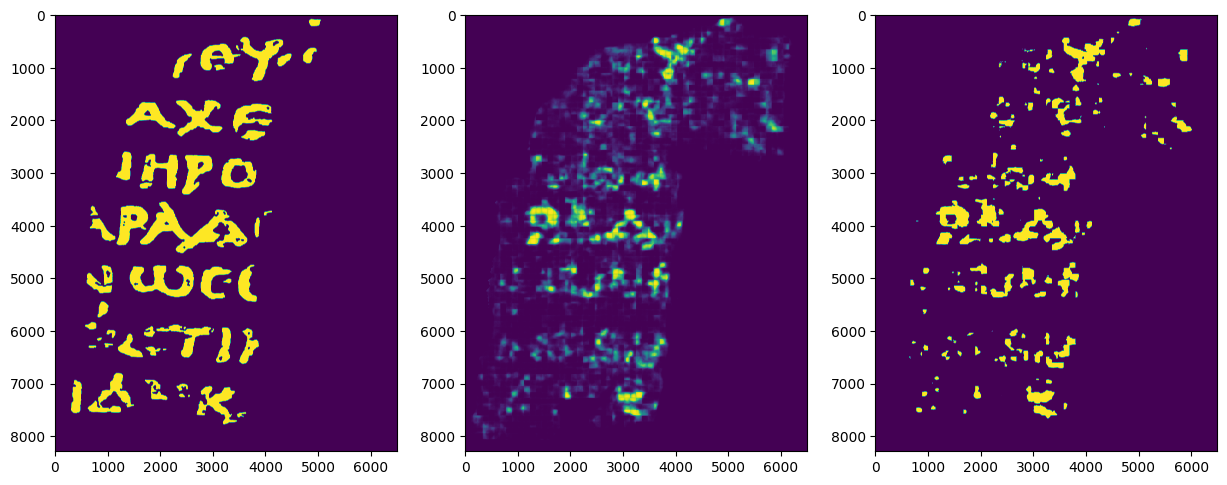

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([43898064.,  2958151.,  1518915.,   977114.,   701211.,   559107.,
          431359.,   351848.,   306486.,   269544.,   235659.,   213756.,
          197121.,   178322.,   170209.,   147881.,   140468.,   154728.,
          191844.,   237061.]),
 array([9.18135948e-16, 4.99789007e-02, 9.99578014e-02, 1.49936702e-01,
        1.99915603e-01, 2.49894504e-01, 2.99873404e-01, 3.49852305e-01,
        3.99831206e-01, 4.49810106e-01, 4.99789007e-01, 5.49767908e-01,
        5.99746808e-01, 6.49725709e-01, 6.99704610e-01, 7.49683511e-01,
        7.99662411e-01, 8.49641312e-01, 8.99620213e-01, 9.49599113e-01,
        9.99578014e-01]),
 <BarContainer object of 20 artists>)

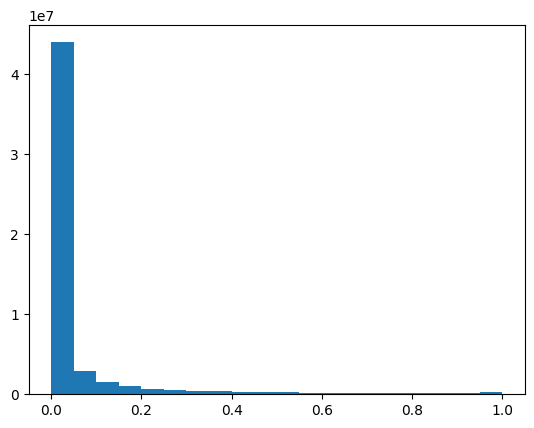

In [34]:
plt.hist(mask_pred.flatten(), bins=20)